# Train DL

> Deep neural nets for PSSM

## Setup

In [ ]:
#| default_exp dl

In [ ]:
#| export
import pandas as pd, numpy as np
import fastcore.all as fc
from torch.utils.data import WeightedRandomSampler
from fastai.vision.all import *

# katlas
from katlas.data import Data
from katlas.feature import *
from katlas.train import *

# sklearn
from sklearn.model_selection import *
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr,pearsonr

In [154]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import fastcore.all as fc


import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *

## Utils

In [6]:
#| export
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
seed_everything()

In [8]:
#| export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
def_device

'cuda'

## Load Data

In [23]:
df=pd.read_parquet('paper/train/pspa_t5.parquet')

In [24]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']

pspa_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)

splits = get_splits(pspa_info, group='subfamily',nfold=5)

split0 = splits[0]

GroupKFold(n_splits=5, random_state=None, shuffle=False)
# subfamily in train set: 120
# subfamily in test set: 29


In [25]:
df=df.reset_index()

In [28]:
df.columns

Index(['index', '-5P', '-5G', '-5A', '-5C', '-5S', '-5T', '-5V', '-5I', '-5L',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1255)

In [29]:
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [30]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

In [31]:
target_col

Index(['-5P', '-5G', '-5A', '-5C', '-5S', '-5T', '-5V', '-5I', '-5L', '-5M',
       ...
       '4H', '4K', '4R', '4Q', '4N', '4D', '4E', '4pS', '4pT', '4pY'],
      dtype='object', length=230)

## Dataset

In [33]:
#| export
class GeneralDataset(Dataset):
    def __init__(self,
                 df,
                 feat_col,            # list/Index of feature columns (e.g., 100 cols)
                 target_col=None,     # list/Index of flattened PSSM cols; AA-first; A=23
                 A: int = 23,
                 dtype=np.float32):
        """
        If target_col is None -> test mode, returns only X.
        Otherwise returns (X, y) where y has shape (23, L), L inferred from target columns.
        """
        self.test = target_col is None
        self.A = A

        # Features
        self.X = df[feat_col].to_numpy(dtype=dtype, copy=True)

        self.y = None
        if not self.test:
            y_flat = df[target_col].to_numpy(dtype=dtype, copy=True)

            total = y_flat.shape[1]
            if total % A != 0:
                raise ValueError(f"Target columns ({total}) not divisible by A={A}; cannot infer L.")
            self.position = total // A

            # AA-first: reshape to (N, 23, L)
            self.y = y_flat.reshape(-1, A, self.position)
        else:
            self.position = None

        self.len = len(df)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        X = torch.from_numpy(self.X[index])        # (feat_dim,)
        if self.test: return X
        y = torch.from_numpy(self.y[index])        # (23, L)
        return X, y

In [34]:
# dataset
ds = GeneralDataset(df,feat_col,target_col)

In [35]:
len(ds)

368

In [38]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [39]:
xb,yb = next(iter(dl))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Models

### MLP

In [45]:
#| export
def MLP_1(num_features, 
          num_targets,
          hidden_units = [512, 218],
          dp = 0.2):
    
    # Start with the first layer from num_features to the first hidden layer
    layers = [
        nn.Linear(num_features, hidden_units[0]),
        nn.BatchNorm1d(hidden_units[0]),
        nn.Dropout(dp),
        nn.PReLU()
    ]
    
    # Loop over hidden units to create intermediate layers
    for i in range(len(hidden_units) - 1):
        layers.extend([
            nn.Linear(hidden_units[i], hidden_units[i+1]),
            nn.BatchNorm1d(hidden_units[i+1]),
            nn.Dropout(dp),
            nn.PReLU()
        ])
    
    # Add the output layer
    layers.append(nn.Linear(hidden_units[-1], num_targets))
    
    model = nn.Sequential(*layers)
    
    return model

In [46]:
n_feature = len(feat_col)
n_target = len(target_col)

In [47]:
model = MLP_1(n_feature, n_target)

In [48]:
model(xb)

tensor([[-0.5601,  0.3075, -1.0476,  ...,  0.5810,  0.4464,  0.9879],
        [ 0.3360, -0.8909,  0.2644,  ..., -0.3754, -0.4358, -0.0953],
        [-0.1941,  0.3228, -0.7018,  ...,  0.1431,  0.1255, -0.0273],
        ...,
        [ 0.1831, -0.1087, -0.1020,  ...,  0.0447,  0.2234, -0.0169],
        [-0.0887,  1.1358, -1.9254,  ..., -0.1750, -0.4655,  0.9545],
        [-0.3484,  0.5287, -0.3195,  ...,  0.3626,  0.1834, -0.2491]],
       grad_fn=<AddmmBackward0>)

### CNN1D

***Version 1***

In [49]:
#| export
class CNN1D_1(Module):
    
    def __init__(self, 
                 num_features, # this does not matter, just for format
                 num_targets):

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.flatten = Flatten()
        self.fc1 = nn.Linear(in_features = int(8 * num_features/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_targets)

    def forward(self, x):
        x = x.unsqueeze(1) # need shape (bs, 1, num_features) for CNN
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        # x = torch.flatten(x, 1)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [50]:
model = CNN1D_1(n_feature, n_target)

In [51]:
model(xb)

tensor([[ 0.0272, -0.0864, -0.0076,  ...,  0.0709,  0.0641,  0.0163],
        [ 0.0285, -0.0863, -0.0074,  ...,  0.0716,  0.0635,  0.0168],
        [ 0.0272, -0.0870, -0.0072,  ...,  0.0709,  0.0637,  0.0163],
        ...,
        [ 0.0274, -0.0871, -0.0080,  ...,  0.0708,  0.0642,  0.0175],
        [ 0.0274, -0.0872, -0.0083,  ...,  0.0710,  0.0650,  0.0175],
        [ 0.0276, -0.0866, -0.0076,  ...,  0.0725,  0.0644,  0.0155]],
       grad_fn=<AddmmBackward0>)

***Version 2***

In [58]:
#| export
def init_weights(m, leaky=0.):
    "Initiate any Conv layer with Kaiming norm."
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): nn.init.kaiming_normal_(m.weight, a=leaky)

In [53]:
#| export
def lin_wn(ni,nf,dp=0.1,act=nn.SiLU):
    "Weight norm of linear."
    layers =  nn.Sequential(
            nn.BatchNorm1d(ni),
            nn.Dropout(dp),
            nn.utils.weight_norm(nn.Linear(ni, nf)) )
    if act: layers.append(act())
    return layers

In [54]:
#| export
def conv_wn(ni, nf, ks=3, stride=1, padding=1, dp=0.1,act=nn.ReLU):
    "Weight norm of conv."
    layers =  nn.Sequential(
        nn.BatchNorm1d(ni),
        nn.Dropout(dp),
        nn.utils.weight_norm(nn.Conv1d(ni, nf, ks, stride, padding)) )
    if act: layers.append(act())
    return layers

In [55]:
#| export
class CNN1D_2(nn.Module):
    
    def __init__(self, ni, nf, amp_scale = 16):
        super().__init__()

        cha_1,cha_2,cha_3 = 256,512,512
        hidden_size = cha_1*amp_scale

        cha_po_1 = hidden_size//(cha_1*2)
        cha_po_2 = (hidden_size//(cha_1*4)) * cha_3
        
        self.lin = lin_wn(ni,hidden_size)
        
        # bs, 256, 16
        self.view = View(-1,cha_1,amp_scale)
        
        self.conv1 = nn.Sequential(
            conv_wn(cha_1, cha_2, ks=5, stride=1, padding=2, dp=0.1),
            nn.AdaptiveAvgPool1d(output_size = cha_po_1),
            conv_wn(cha_2, cha_2, ks=3, stride=1, padding=1, dp=0.1))
        
        self.conv2 = nn.Sequential(
            conv_wn(cha_2, cha_2, ks=3, stride=1, padding=1, dp=0.3),
            conv_wn(cha_2, cha_3, ks=5, stride=1, padding=2, dp=0.2))
        
        self.head = nn.Sequential(
            nn.MaxPool1d(kernel_size=4, stride=2, padding=1),
            nn.Flatten(),
            lin_wn(cha_po_2,nf,act=None) )


    def forward(self, x):
        # amplify features to 4096
        x = self.lin(x)
        
        # reshape to bs,256,16 for conv1d
        x = self.view(x) 

        x = self.conv1(x)
        
        x_s = x  # for skip connection (multiply)
        x = self.conv2(x)
        x = x * x_s

        # Final block
        x = self.head(x)

        return x

In [59]:
model = CNN1D_2(n_feature,n_target).apply(init_weights)

In [61]:
model(xb).shape

torch.Size([64, 230])

## Wrapper

In [85]:
#| export
class PSSM_model(nn.Module):
    def __init__(self, 
                 n_features,
                 n_targets,
                 model='MLP'):
        super().__init__()
        self.n_features=n_features
        self.n_targets=n_targets
        self.n_aa = 23
        if self.n_targets % self.n_aa != 0: raise ValueError(f"n_targets ({n_targets}) must be divisible by n_aa ({n_aa}).")
        self.n_positions = self.n_targets//self.n_aa
        
        if model =='MLP': self.model=MLP_1(self.n_features, self.n_targets)
        elif model =='CNN': self.model=CNN1D_2(self.n_features, self.n_targets).apply(init_weights)
        else: raise ValueError('model must be MLP or CNN.')
    def forward(self,x):
        logits = self.model(x).reshape(-1, self.n_aa,self.n_positions)
        # probs  = F.softmax(logits, dim=1)
        # return logits, probs
        return logits

In [210]:
model = PSSM_model(n_feature,n_target)

In [211]:
logits= model(xb)

In [212]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [81]:
#| export
def CE(logits: torch.Tensor,
       target_probs: torch.Tensor,
      ):
    """
    Cross-entropy with soft labels.
    logits:       (B, 20, 10)
    target_probs: (B, 20, 10), each column (over AA) sums to 1
    """
    logp = F.log_softmax(logits, dim=1)              # (B, 20, 10)
    ce   = -(target_probs * logp).sum(dim=1)         # (B, 10)
    return ce.mean()

In [185]:
CE(logits,yb)

tensor(3.2360, grad_fn=<MeanBackward0>)

## DL Trainer

In [134]:
#| export
def train_dl(df, 
            feat_col, 
            target_col,
            split, # tuple of numpy array for split index
            model, # function to get pytorch model
             n_epoch = 4, # number of epochs
             bs = 32, # batch size
             lr = 1e-2, # will be useless if lr_find is True
            loss = CE, # loss function
            save = None, # models/{save}.pth
             sampler = None,
             lr_find=False, # if true, will use lr from lr_find
              ):
    "A DL trainer."
    
    train = df.loc[split[0]]
    valid = df.loc[split[1]]
    
    train_ds = GeneralDataset(train, feat_col, target_col)
    valid_ds = GeneralDataset(valid, feat_col, target_col)
    
    n_workers = fc.defaults.cpus

    dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=bs, num_workers=n_workers)

    
    learn = Learner(dls.to(def_device), model.to(def_device), loss, 
                    # cbs = [GradientClip(1.0)] # prevent overfitting
                   )
    
    if lr_find:
        # get learning rate
        lr = learn.lr_find()
        plt.show()
        plt.close()
        print(lr)

        
    print('lr in training is', lr)
    learn.fit_one_cycle(n_epoch,lr) #cbs = [SaveModelCallback(fname = 'best')] # save best model
    
    if save is not None:
        learn.save(save)
        
    pred,target = learn.get_preds()
    
    pred  = F.softmax(pred, dim=1).reshape(len(valid),-1)
    target = target.reshape(len(valid),-1)
    
    pred = pd.DataFrame(pred.detach().cpu().numpy(),index=valid.index,columns=target_col)
    target = pd.DataFrame(target.detach().cpu().numpy(),index=valid.index,columns=target_col)
    
    return target, pred

In [103]:
model = PSSM_model(n_feature,n_target,model='MLP')

In [135]:
model = PSSM_model(n_feature,n_target,model='CNN')

/home/sky1ove/git/KATLAS/katlas/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


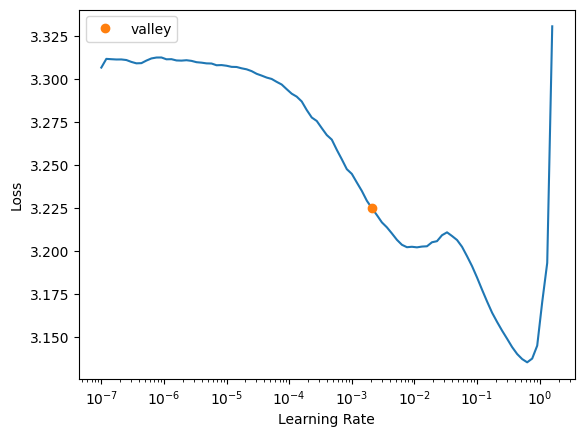

SuggestedLRs(valley=0.0020892962347716093)
lr in training is SuggestedLRs(valley=0.0020892962347716093)


epoch,train_loss,valid_loss,time
0,3.253746,3.127592,00:00
1,3.183302,3.079257,00:00
2,3.133879,3.094230,00:00
3,3.099692,3.046018,00:00
4,3.080591,3.014557,00:00
5,3.058870,2.984305,00:00
6,3.035744,2.919169,00:00
7,3.008566,2.872842,00:00
8,2.985491,2.872450,00:00
9,2.964748,2.866967,00:00


In [136]:
target, pred = train_dl(df, 
                        feat_col, 
                        target_col,
                        split0, 
                        model,
                        n_epoch=20,
                        lr = 2e-3,
                        lr_find=True,
                        save = 'test')

O14965_AURKA_HUMAN_KD1 target


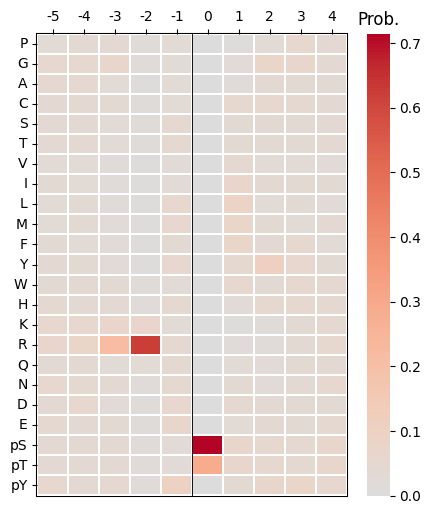

O14965_AURKA_HUMAN_KD1 pred


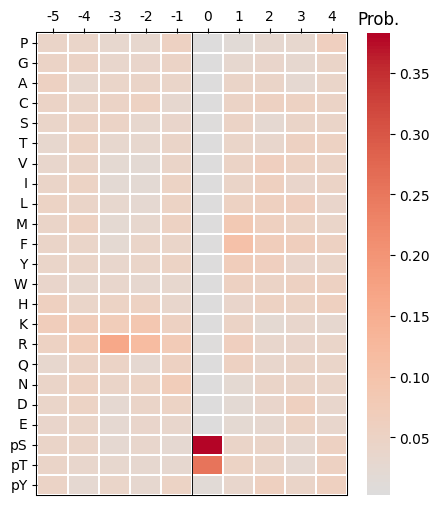

Q96GD4_AURKB_HUMAN_KD1 target


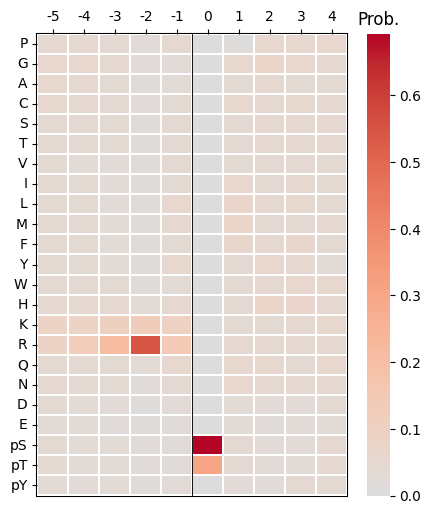

Q96GD4_AURKB_HUMAN_KD1 pred


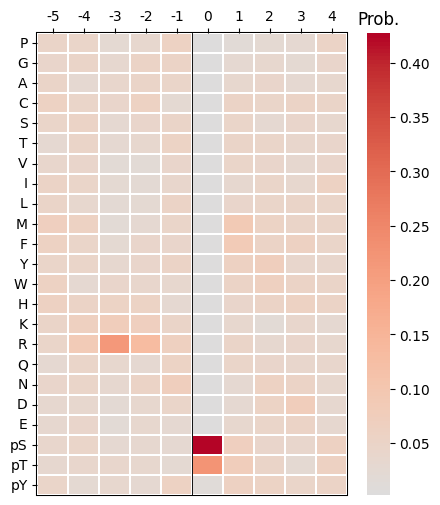

Q9UQB9_AURKC_HUMAN_KD1 target


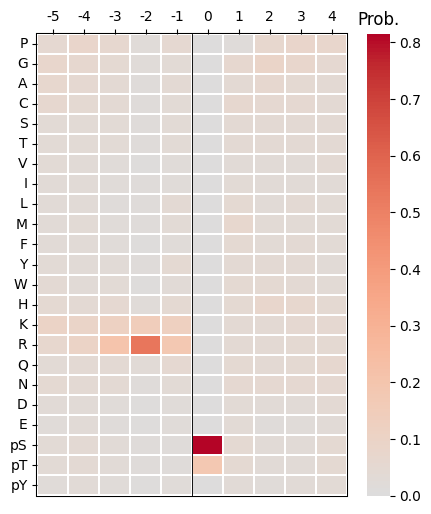

Q9UQB9_AURKC_HUMAN_KD1 pred


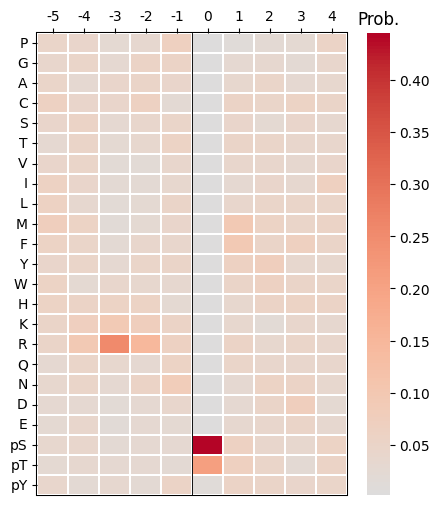

O00311_CDC7_HUMAN_KD1 target


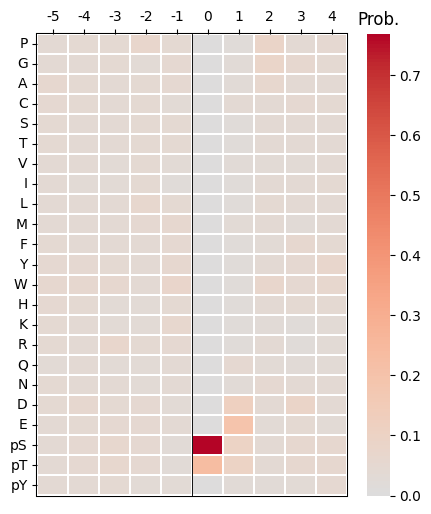

O00311_CDC7_HUMAN_KD1 pred


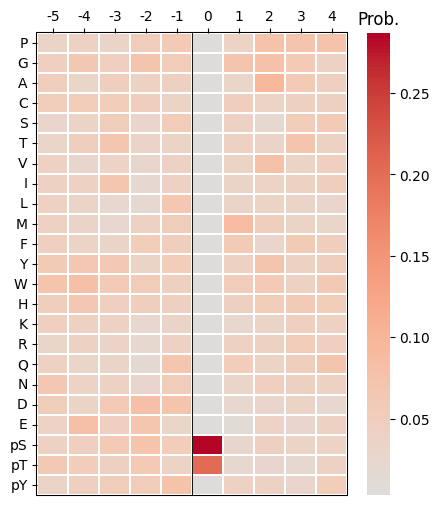

P06493_CDK1_HUMAN_KD1 target


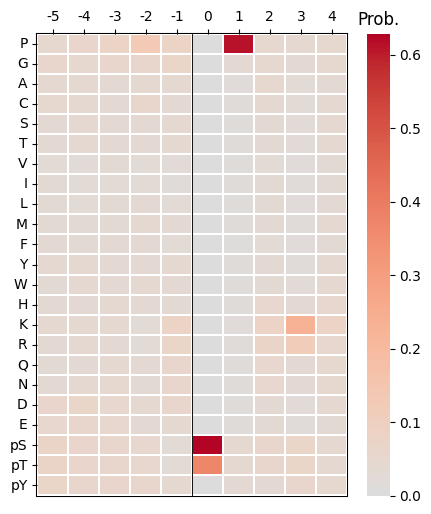

P06493_CDK1_HUMAN_KD1 pred


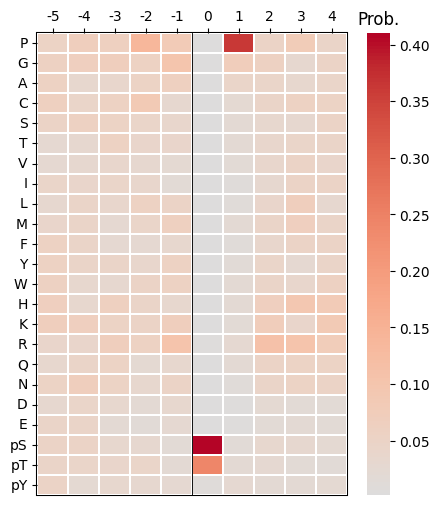

Q9BWU1_CDK19_HUMAN_KD1 target


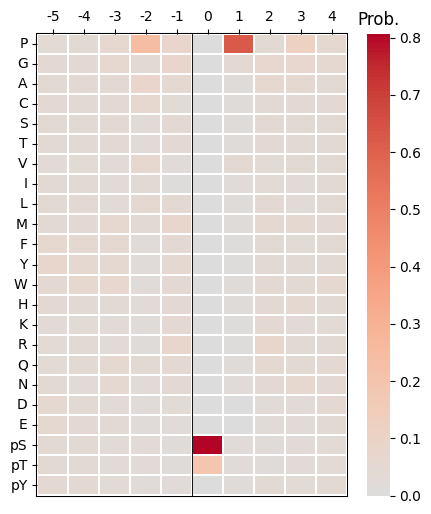

Q9BWU1_CDK19_HUMAN_KD1 pred


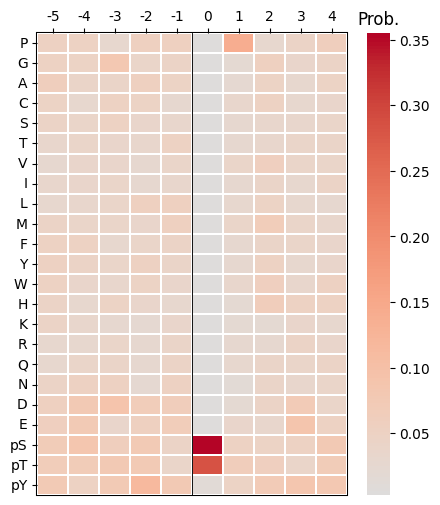

P24941_CDK2_HUMAN_KD1 target


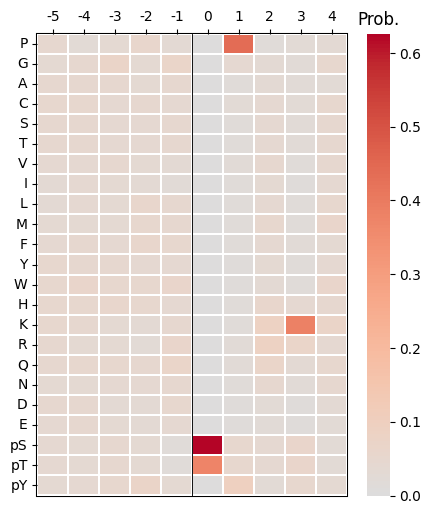

P24941_CDK2_HUMAN_KD1 pred


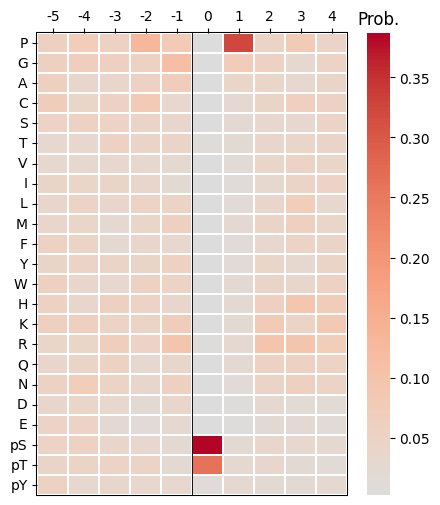

Q00526_CDK3_HUMAN_KD1 target


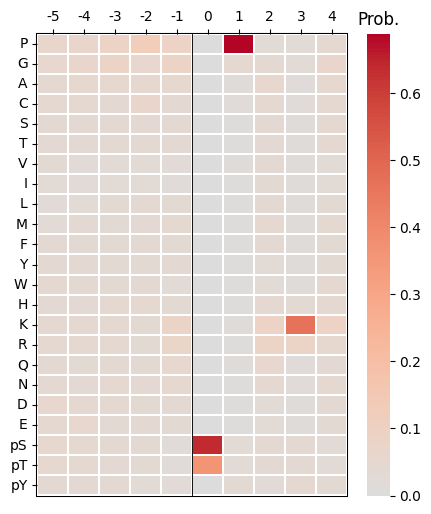

Q00526_CDK3_HUMAN_KD1 pred


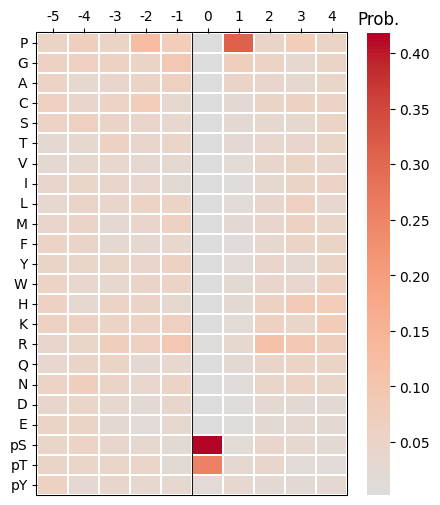

P49336_CDK8_HUMAN_KD1 target


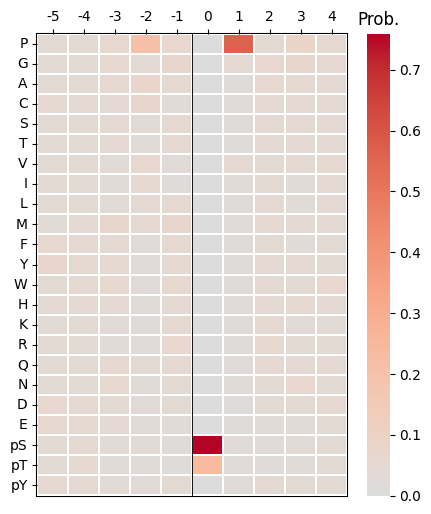

P49336_CDK8_HUMAN_KD1 pred


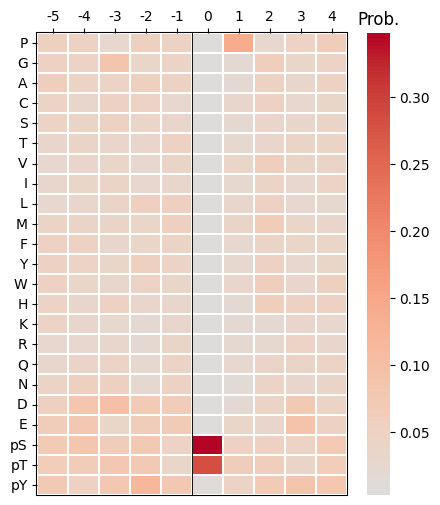

O96017_CHK2_HUMAN_KD1 target


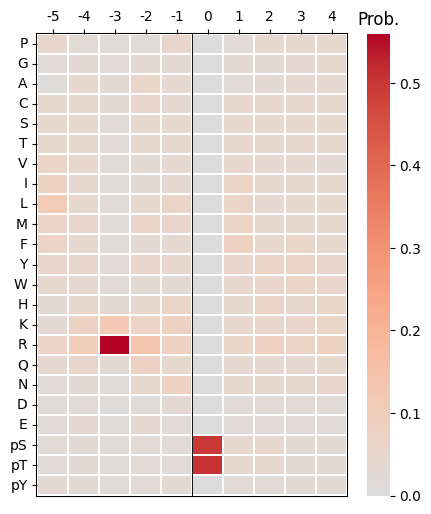

O96017_CHK2_HUMAN_KD1 pred


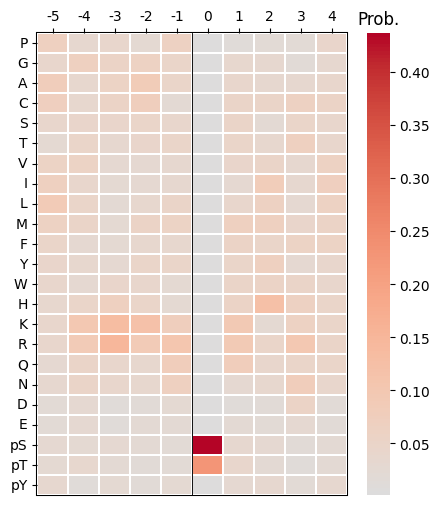

Q13164_MK07_HUMAN_KD1 target


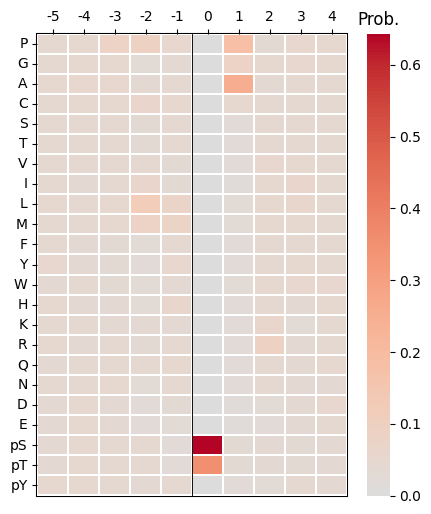

Q13164_MK07_HUMAN_KD1 pred


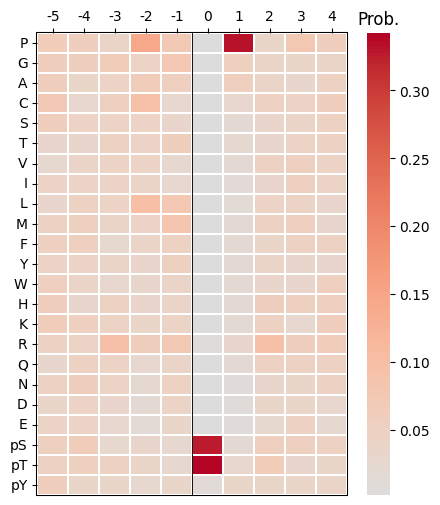

P57058_HUNK_HUMAN_KD1 target


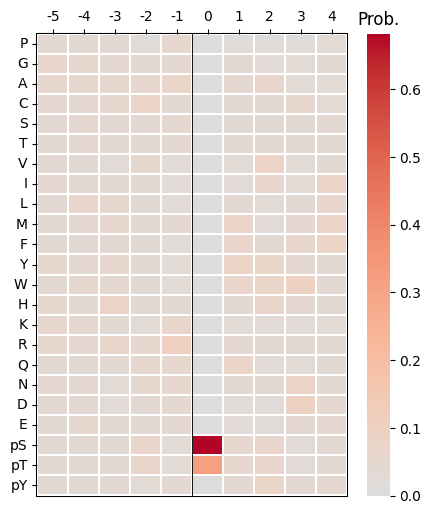

P57058_HUNK_HUMAN_KD1 pred


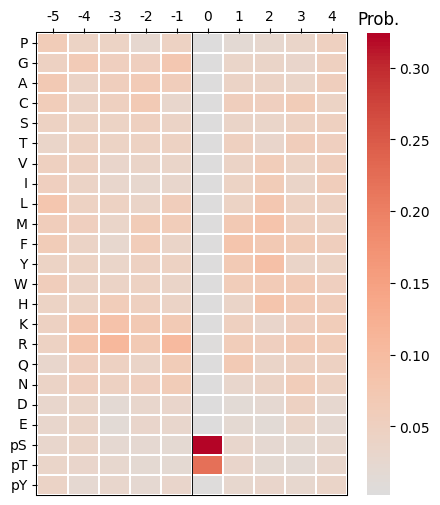

Q9UPZ9_CILK1_HUMAN_KD1 target


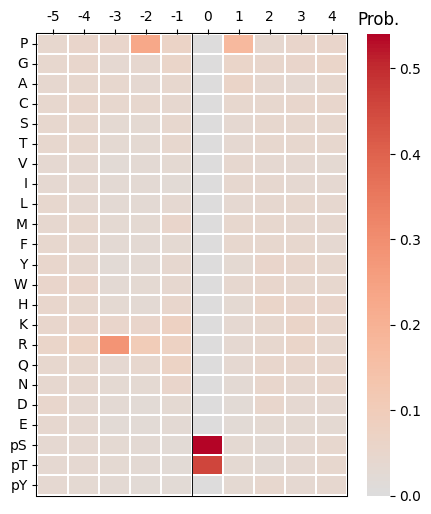

Q9UPZ9_CILK1_HUMAN_KD1 pred


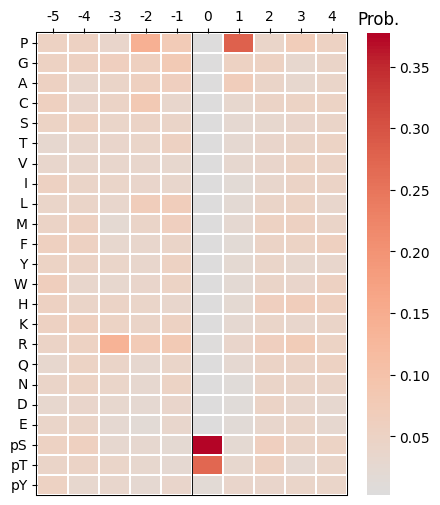

P20794_MAK_HUMAN_KD1 target


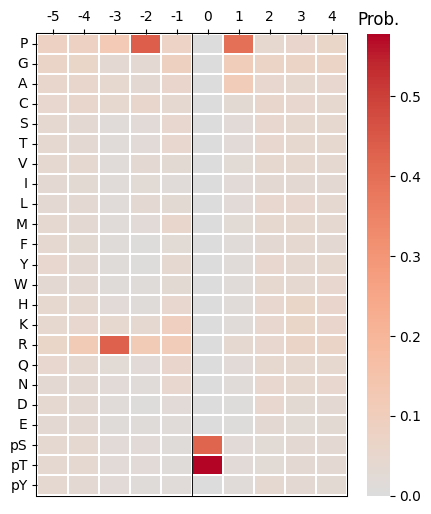

P20794_MAK_HUMAN_KD1 pred


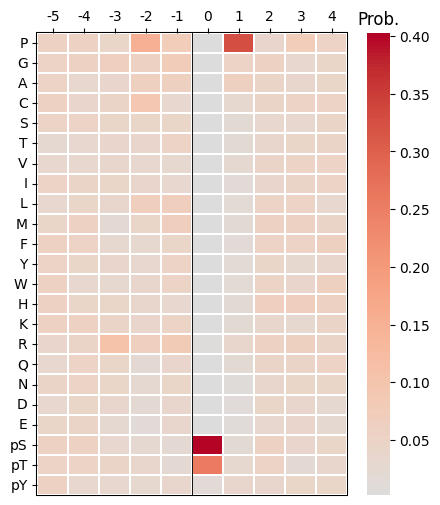

Q8IW41_MAPK5_HUMAN_KD1 target


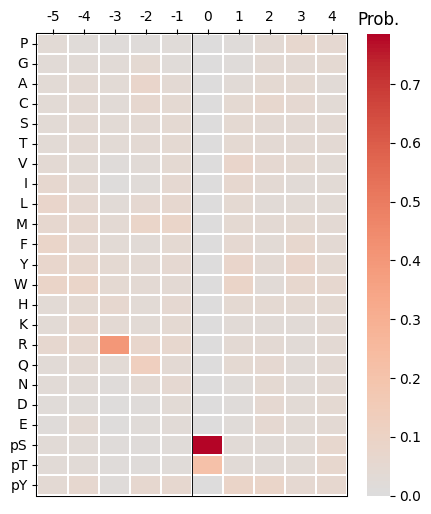

Q8IW41_MAPK5_HUMAN_KD1 pred


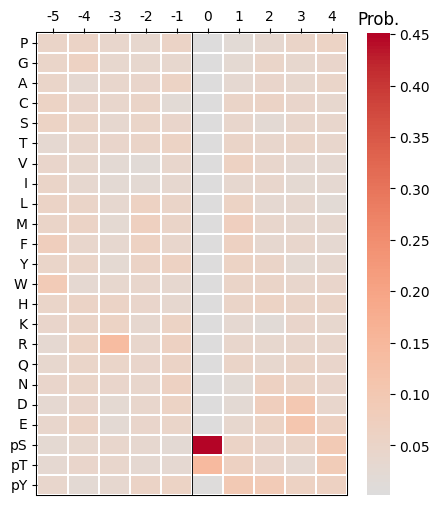

Q9UQ07_MOK_HUMAN_KD1 target


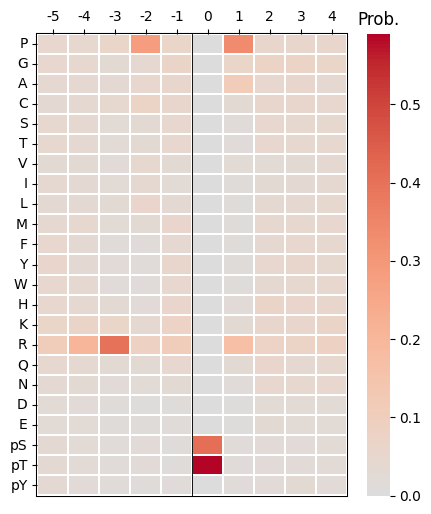

Q9UQ07_MOK_HUMAN_KD1 pred


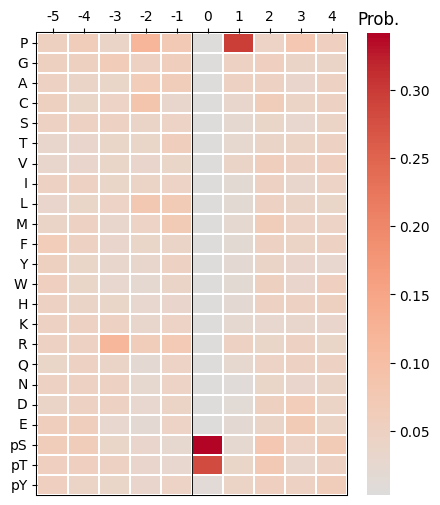

P23443_KS6B1_HUMAN_KD1 target


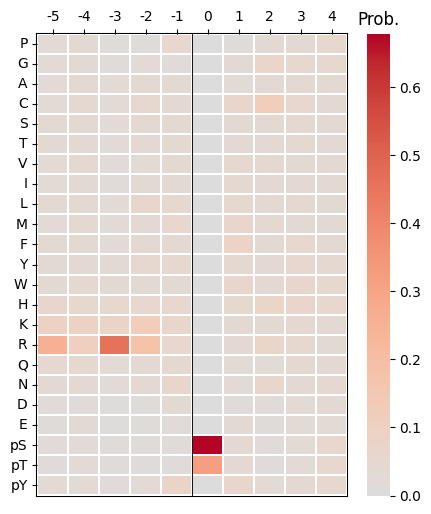

P23443_KS6B1_HUMAN_KD1 pred


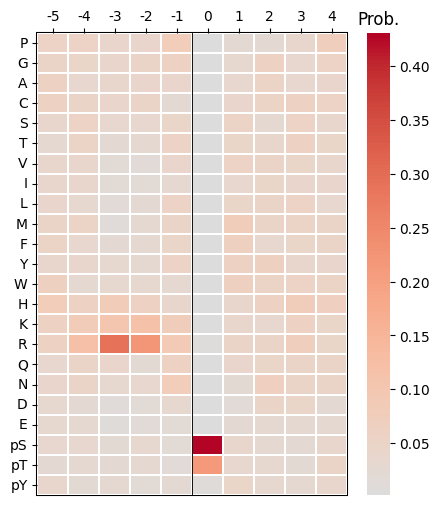

Q9UBS0_KS6B2_HUMAN_KD1 target


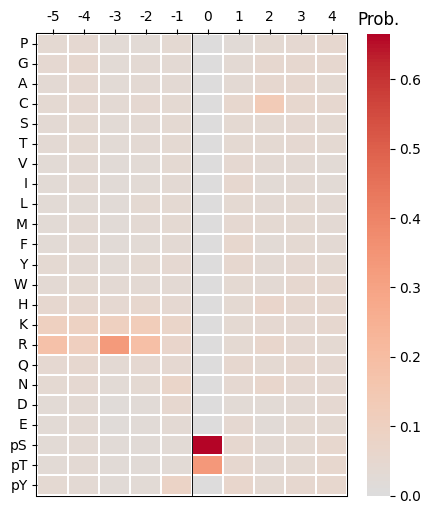

Q9UBS0_KS6B2_HUMAN_KD1 pred


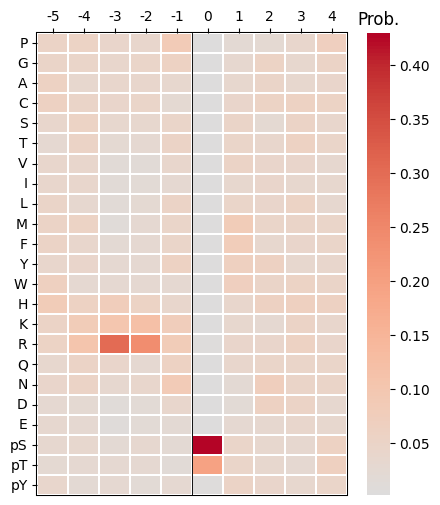

Q15418_KS6A1_HUMAN_KD1 target


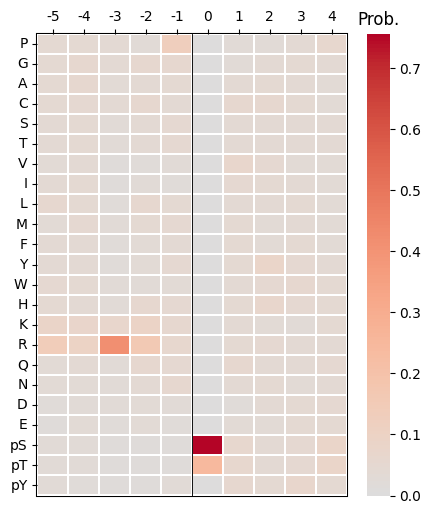

Q15418_KS6A1_HUMAN_KD1 pred


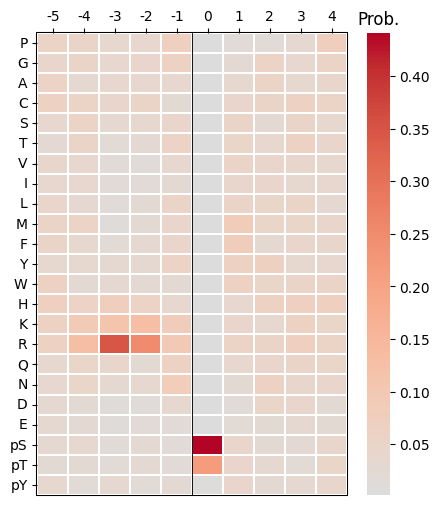

Q9BXM7_PINK1_HUMAN_KD1 target


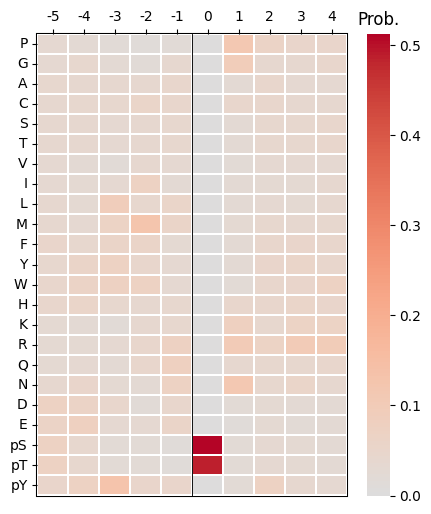

Q9BXM7_PINK1_HUMAN_KD1 pred


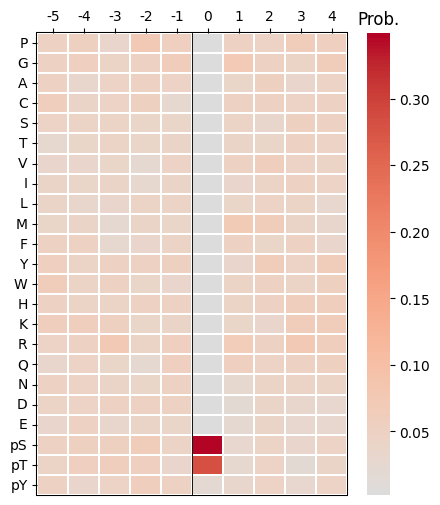

P17612_KAPCA_HUMAN_KD1 target


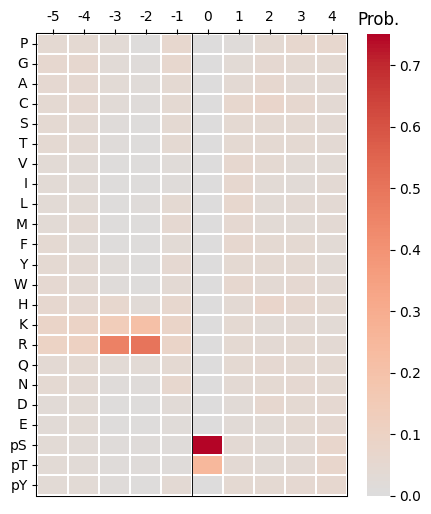

P17612_KAPCA_HUMAN_KD1 pred


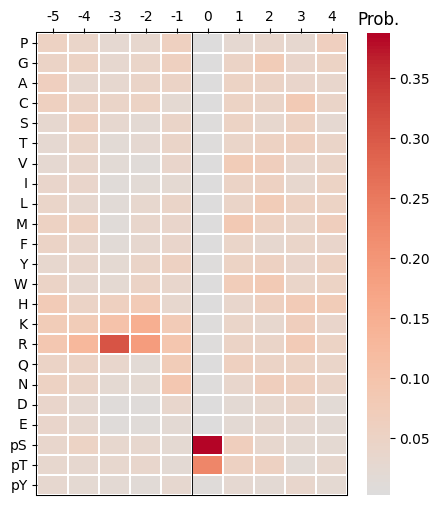

P22694_KAPCB_HUMAN_KD1 target


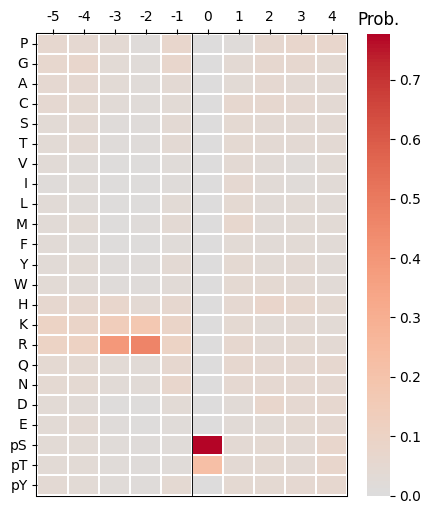

P22694_KAPCB_HUMAN_KD1 pred


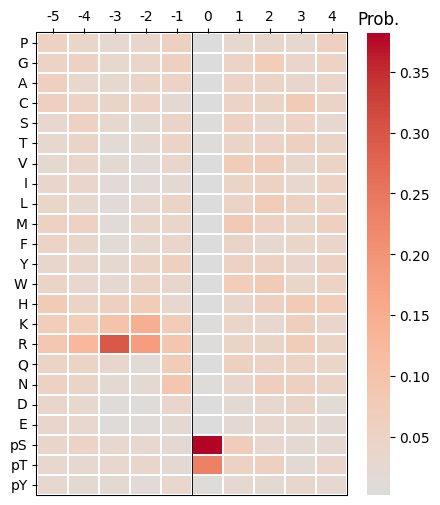

P22612_KAPCG_HUMAN_KD1 target


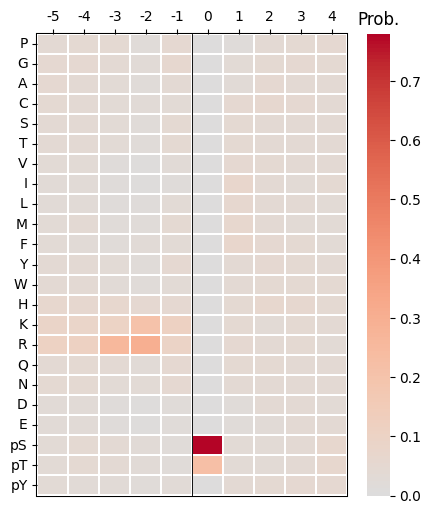

P22612_KAPCG_HUMAN_KD1 pred


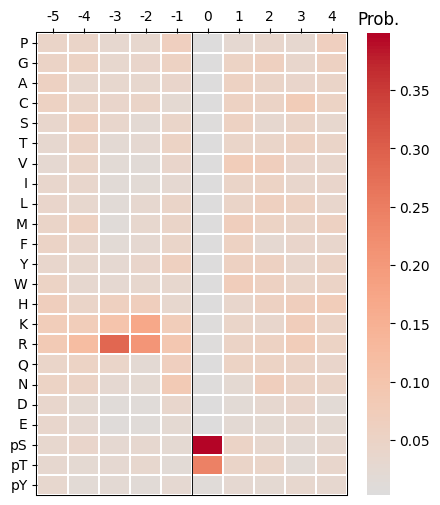

Q02156_KPCE_HUMAN_KD1 target


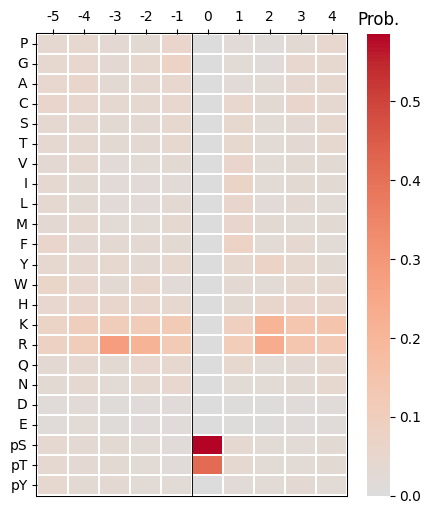

Q02156_KPCE_HUMAN_KD1 pred


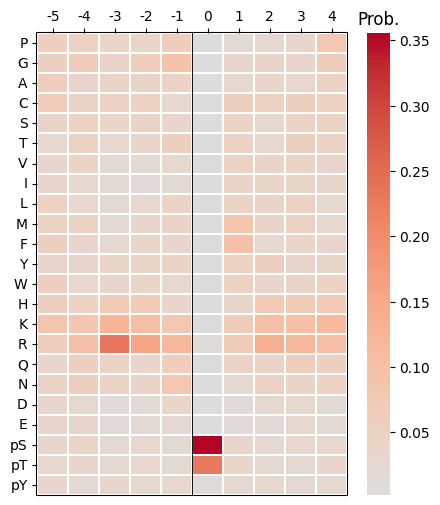

P24723_KPCL_HUMAN_KD1 target


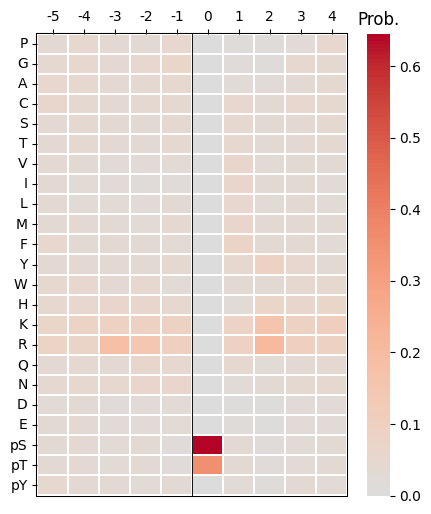

P24723_KPCL_HUMAN_KD1 pred


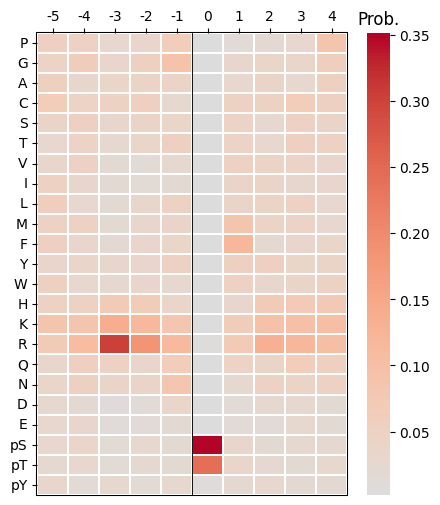

P41743_KPCI_HUMAN_KD1 target


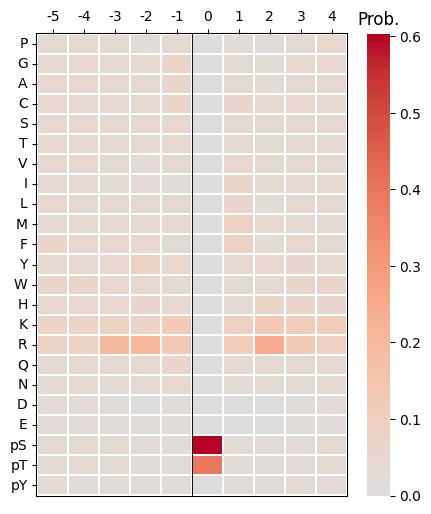

P41743_KPCI_HUMAN_KD1 pred


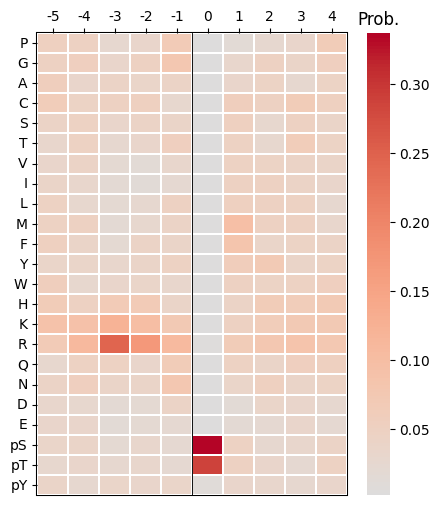

Q05513_KPCZ_HUMAN_KD1 target


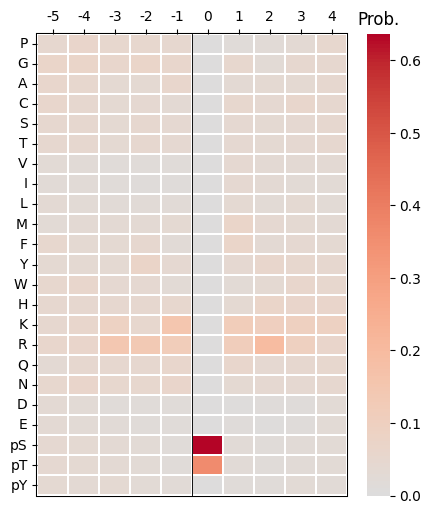

Q05513_KPCZ_HUMAN_KD1 pred


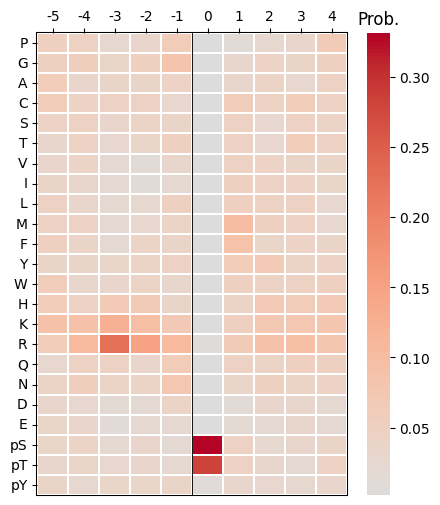

Q15139_KPCD1_HUMAN_KD1 target


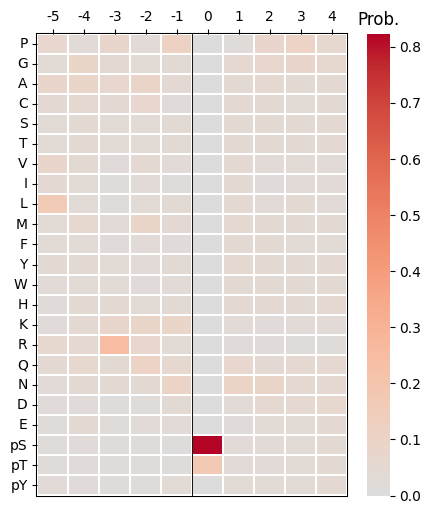

Q15139_KPCD1_HUMAN_KD1 pred


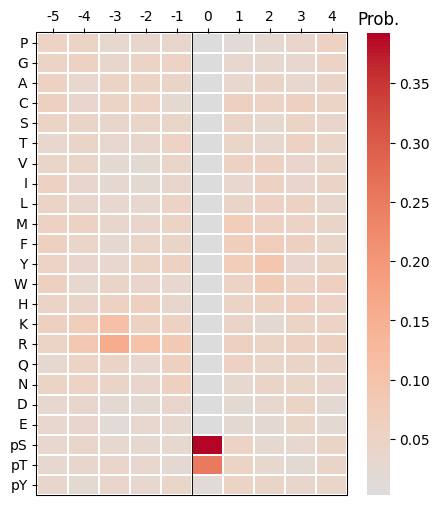

Q9BZL6_KPCD2_HUMAN_KD1 target


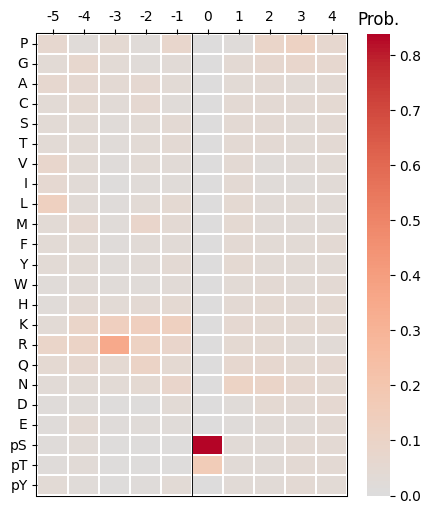

Q9BZL6_KPCD2_HUMAN_KD1 pred


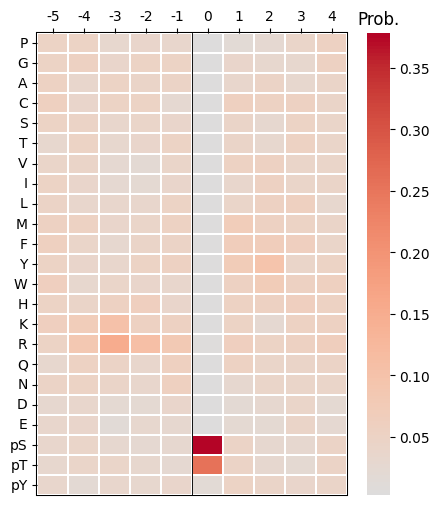

O94806_KPCD3_HUMAN_KD1 target


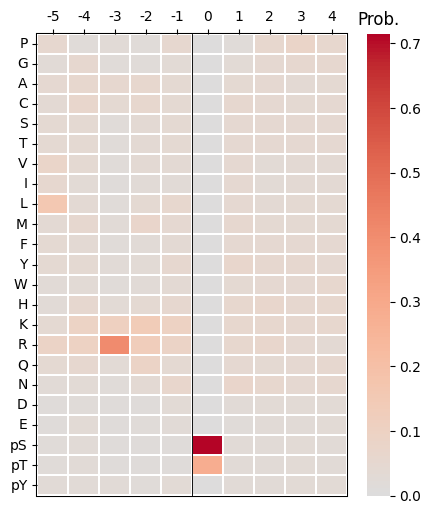

O94806_KPCD3_HUMAN_KD1 pred


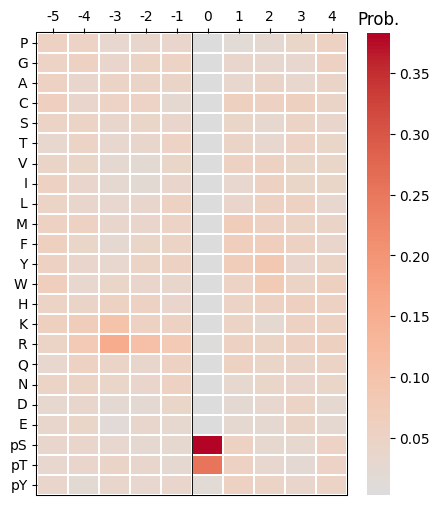

P51817_PRKX_HUMAN_KD1 target


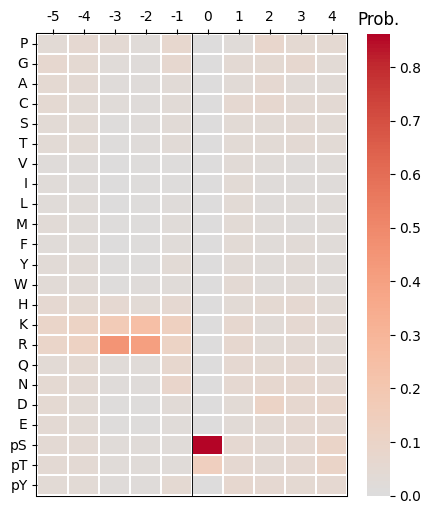

P51817_PRKX_HUMAN_KD1 pred


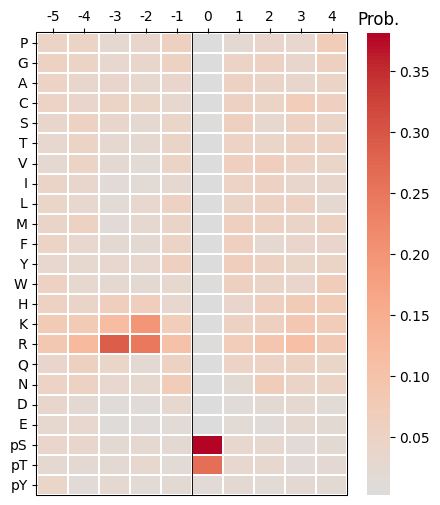

P51812_KS6A3_HUMAN_KD1 target


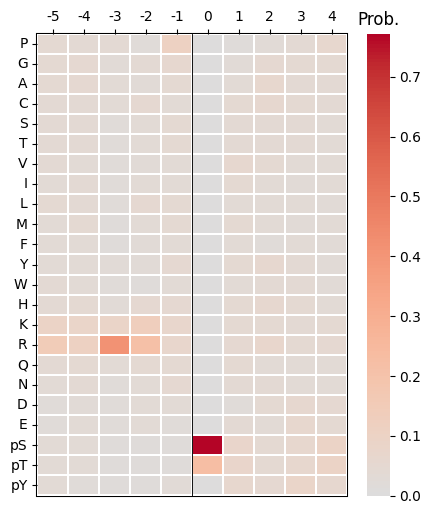

P51812_KS6A3_HUMAN_KD1 pred


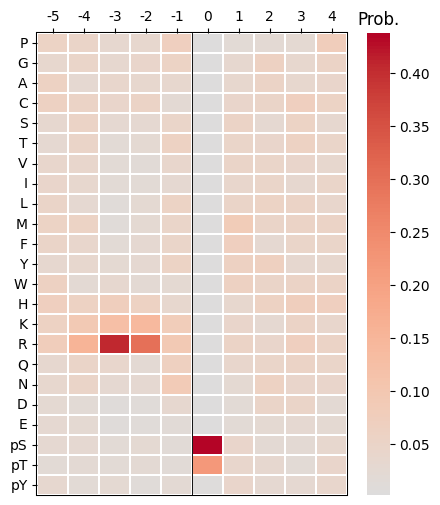

Q15349_KS6A2_HUMAN_KD1 target


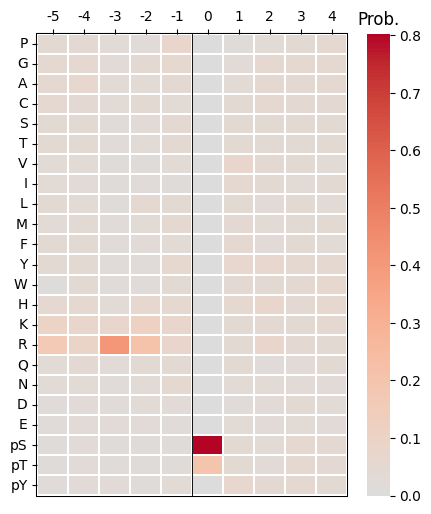

Q15349_KS6A2_HUMAN_KD1 pred


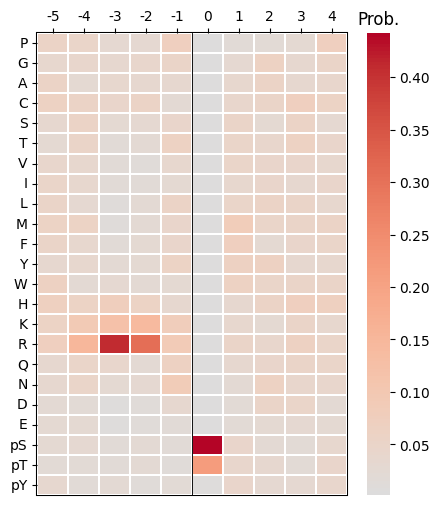

Q9UK32_KS6A6_HUMAN_KD1 target


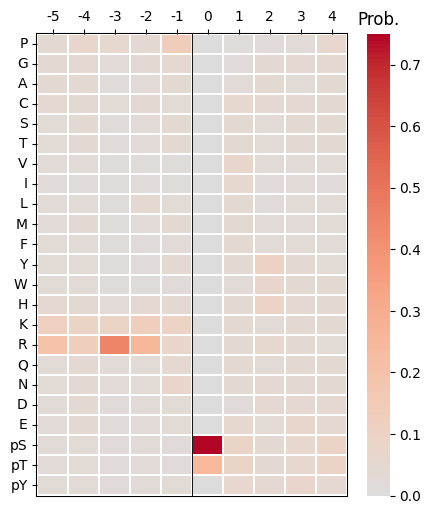

Q9UK32_KS6A6_HUMAN_KD1 pred


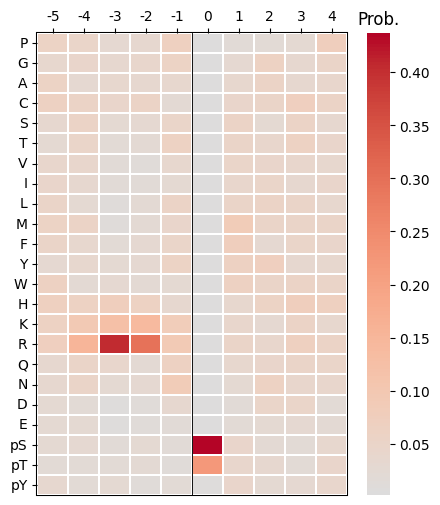

O00141_SGK1_HUMAN_KD1 target


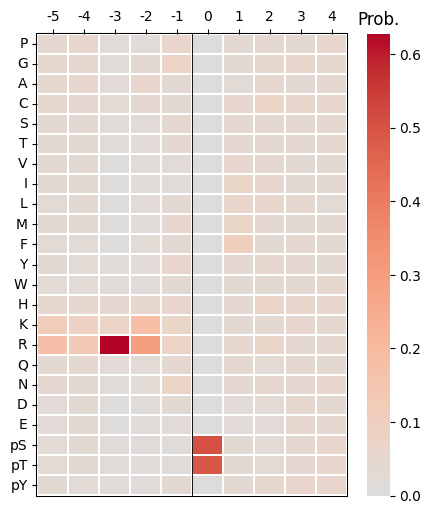

O00141_SGK1_HUMAN_KD1 pred


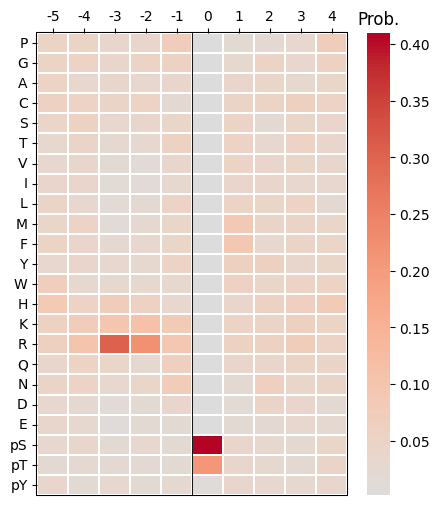

Q96BR1_SGK3_HUMAN_KD1 target


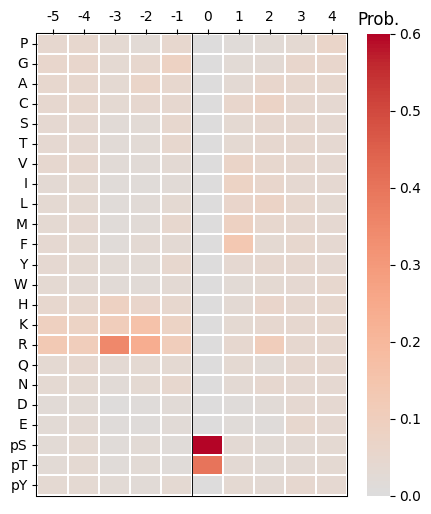

Q96BR1_SGK3_HUMAN_KD1 pred


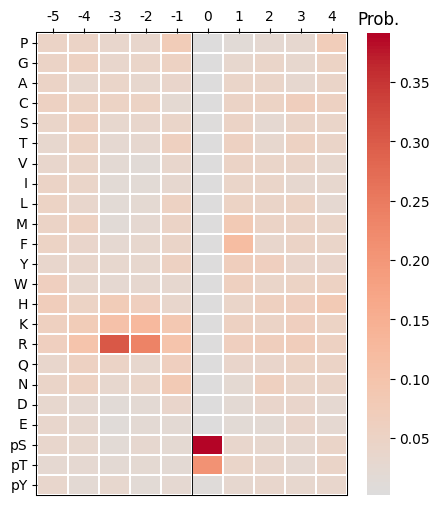

Q9BYT3_STK33_HUMAN_KD1 target


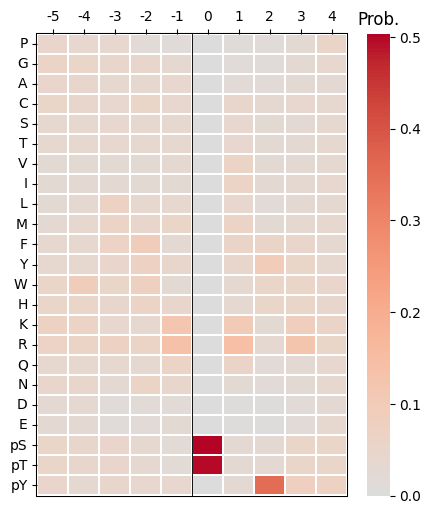

Q9BYT3_STK33_HUMAN_KD1 pred


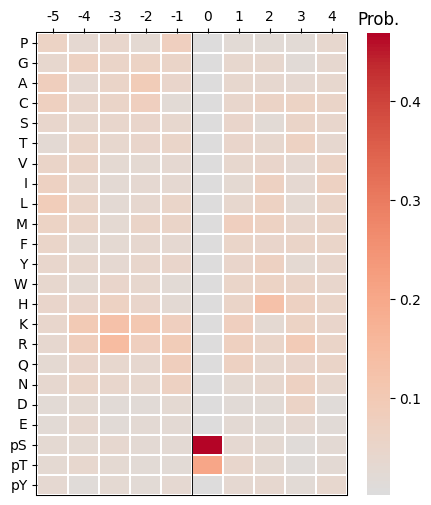

Q7L7X3_TAOK1_HUMAN_KD1 target


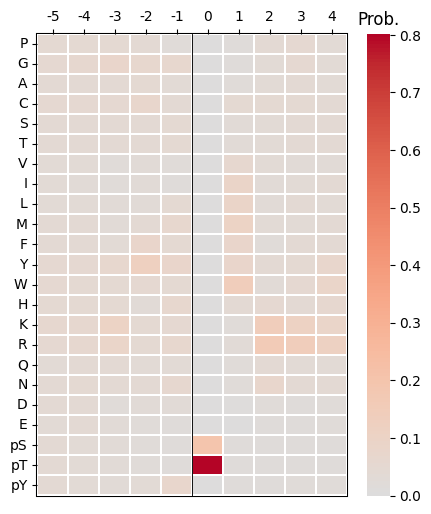

Q7L7X3_TAOK1_HUMAN_KD1 pred


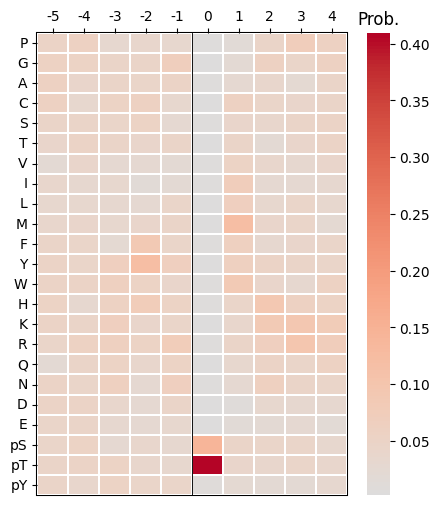

Q9UL54_TAOK2_HUMAN_KD1 target


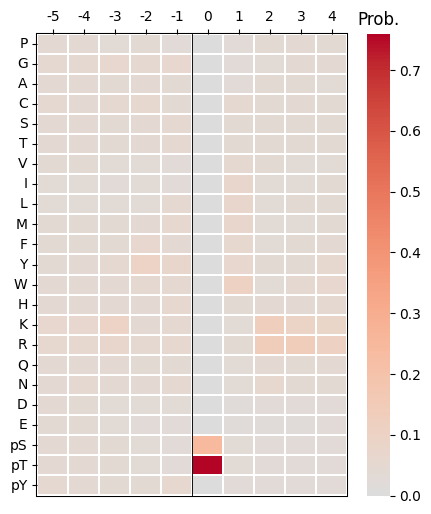

Q9UL54_TAOK2_HUMAN_KD1 pred


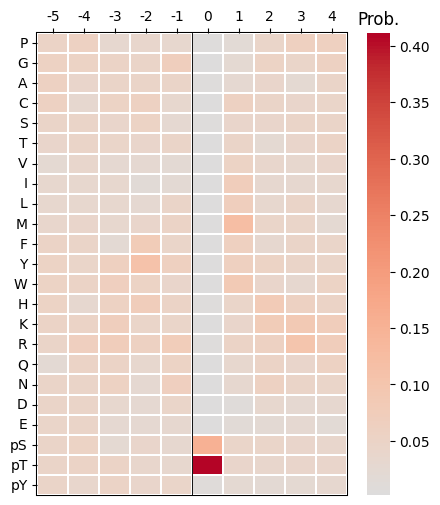

Q9H2K8_TAOK3_HUMAN_KD1 target


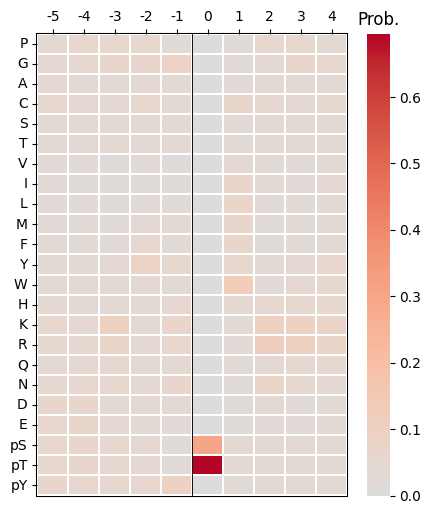

Q9H2K8_TAOK3_HUMAN_KD1 pred


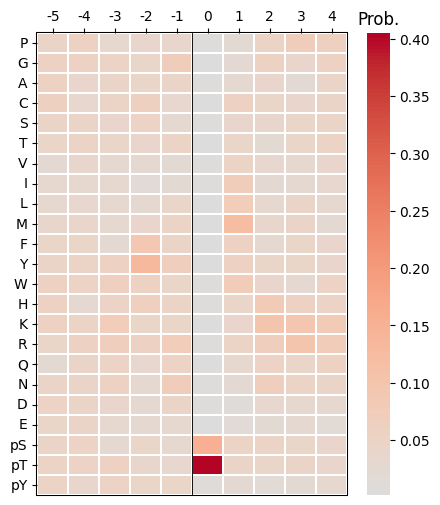

Q9NY57_ST32B_HUMAN_KD1 target


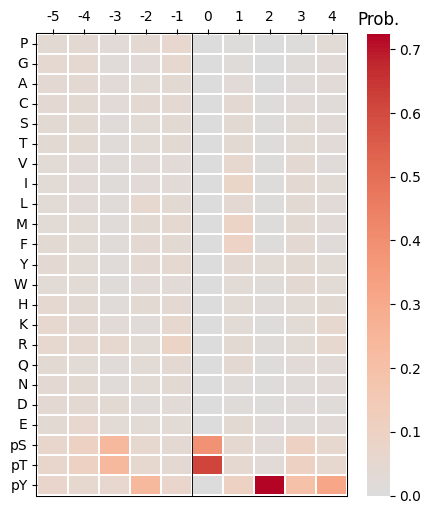

Q9NY57_ST32B_HUMAN_KD1 pred


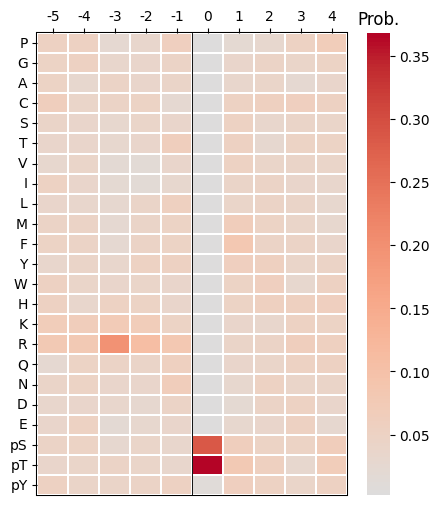

Q86UX6_ST32C_HUMAN_KD1 target


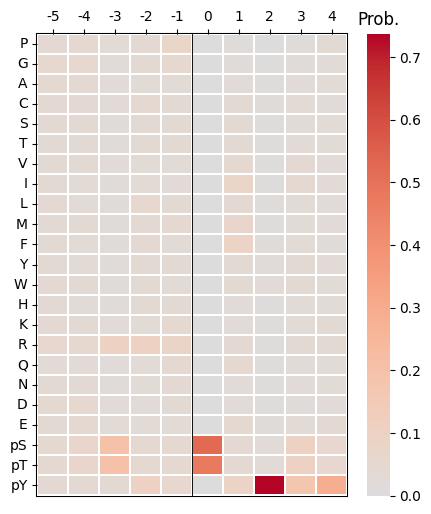

Q86UX6_ST32C_HUMAN_KD1 pred


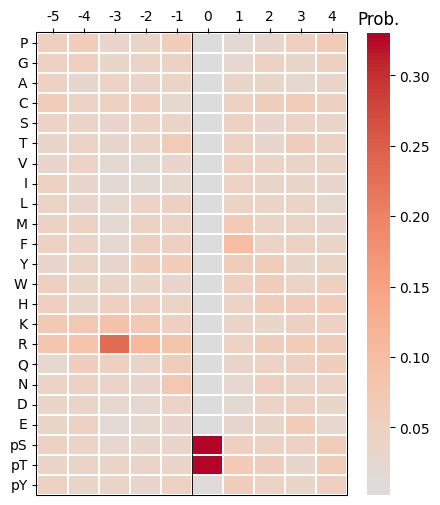

Q07912_ACK1_HUMAN_KD1 target


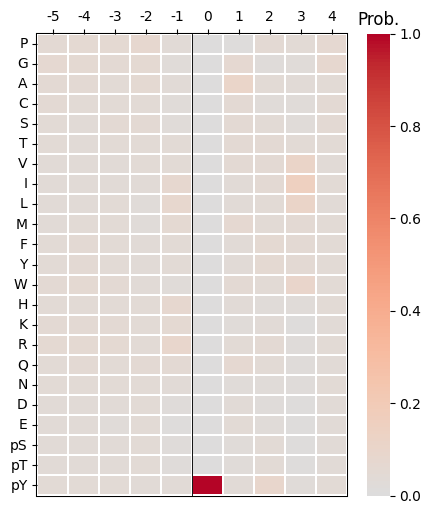

Q07912_ACK1_HUMAN_KD1 pred


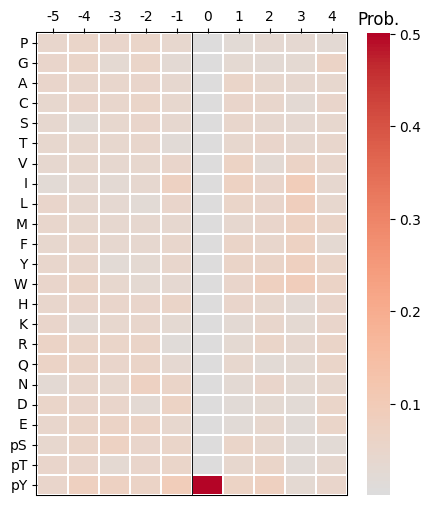

Q9UM73_ALK_HUMAN_KD1 target


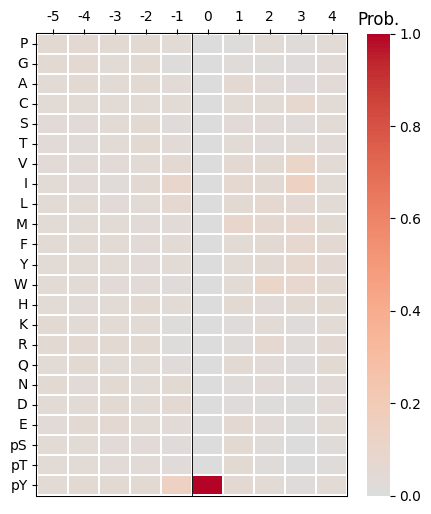

Q9UM73_ALK_HUMAN_KD1 pred


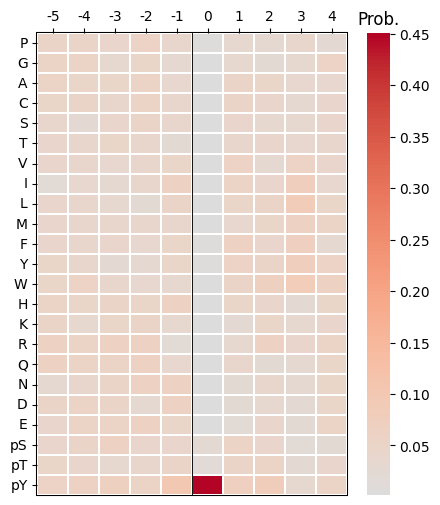

Q06187_BTK_HUMAN_KD1 target


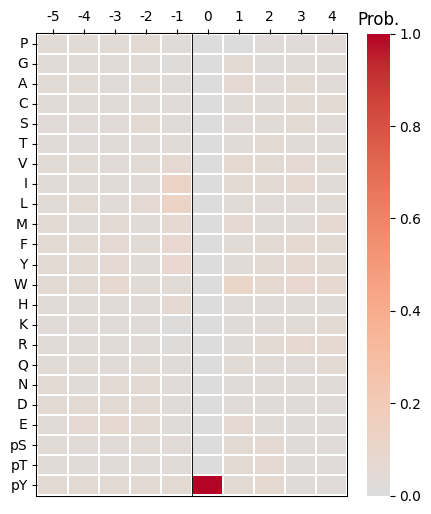

Q06187_BTK_HUMAN_KD1 pred


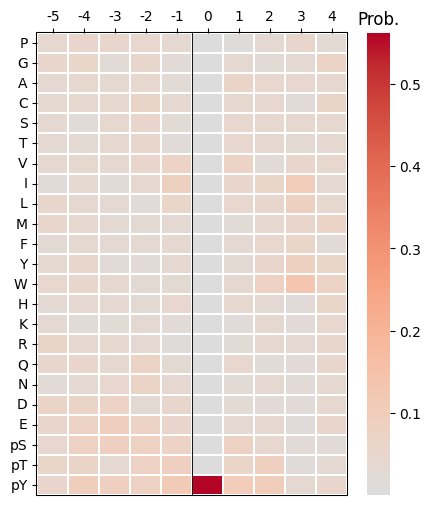

P00533_EGFR_HUMAN_KD1 target


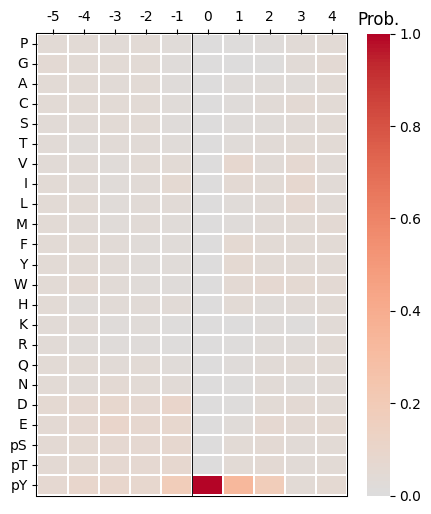

P00533_EGFR_HUMAN_KD1 pred


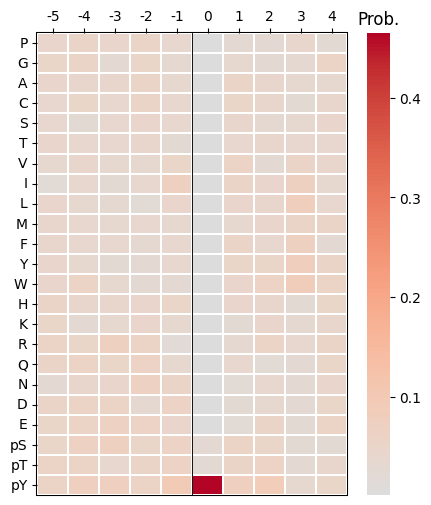

P21709_EPHA1_HUMAN_KD1 target


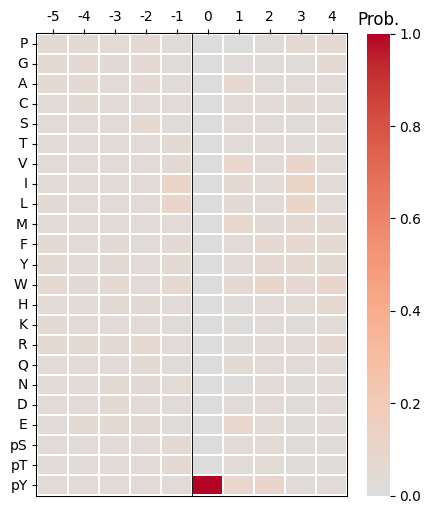

P21709_EPHA1_HUMAN_KD1 pred


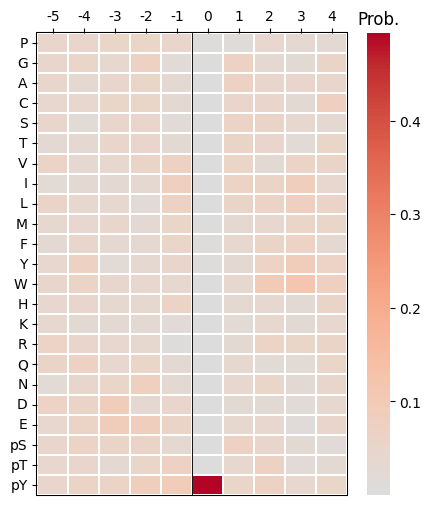

P29317_EPHA2_HUMAN_KD1 target


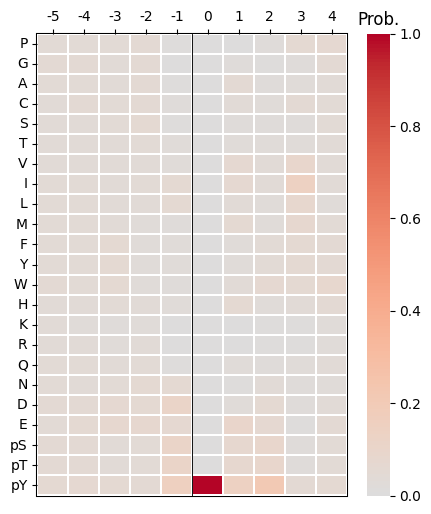

P29317_EPHA2_HUMAN_KD1 pred


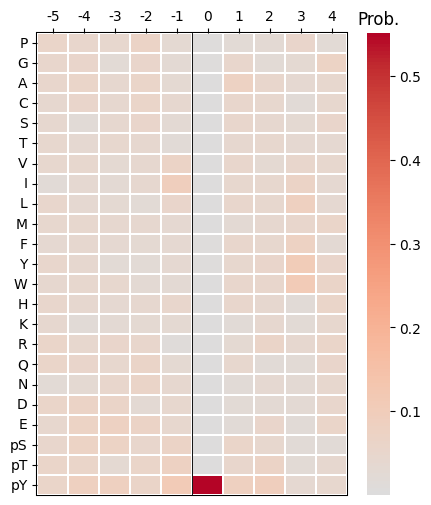

P29320_EPHA3_HUMAN_KD1 target


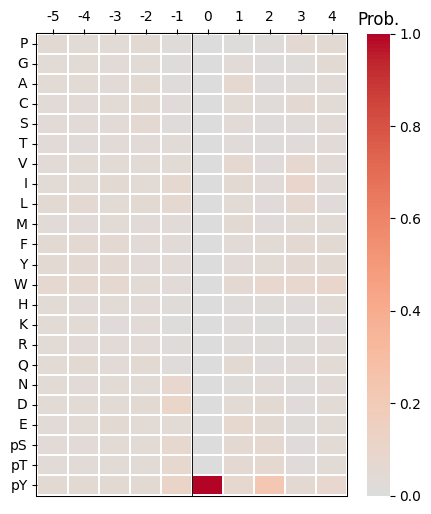

P29320_EPHA3_HUMAN_KD1 pred


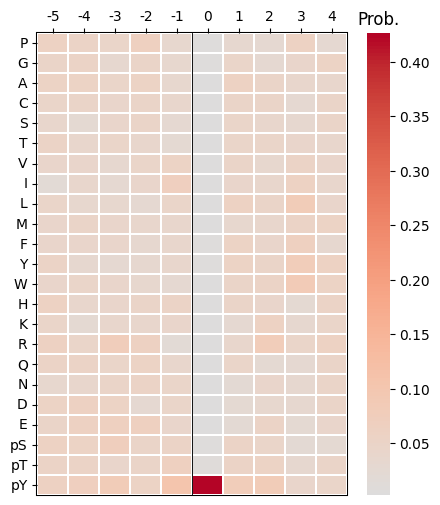

P54764_EPHA4_HUMAN_KD1 target


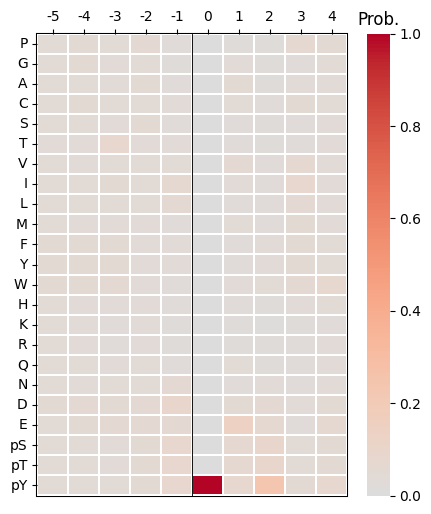

P54764_EPHA4_HUMAN_KD1 pred


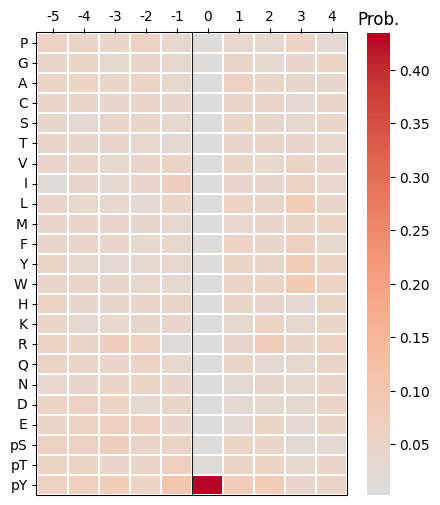

P54756_EPHA5_HUMAN_KD1 target


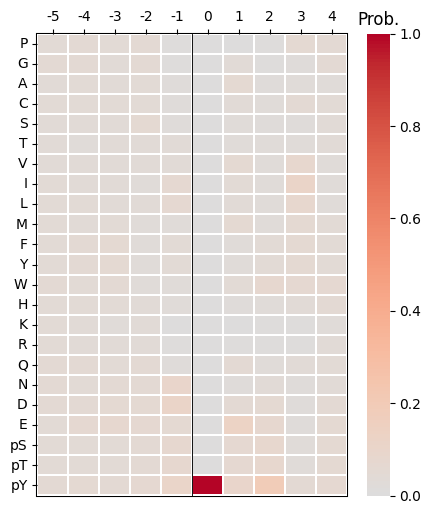

P54756_EPHA5_HUMAN_KD1 pred


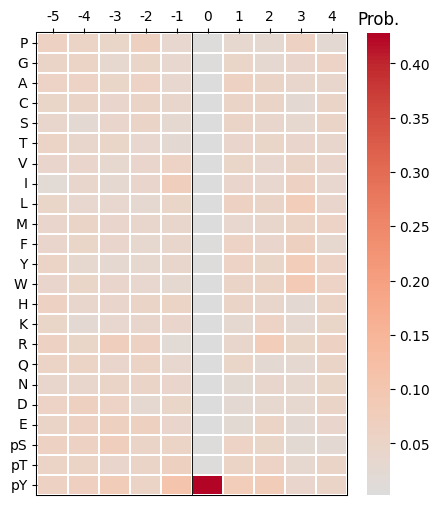

Q9UF33_EPHA6_HUMAN_KD1 target


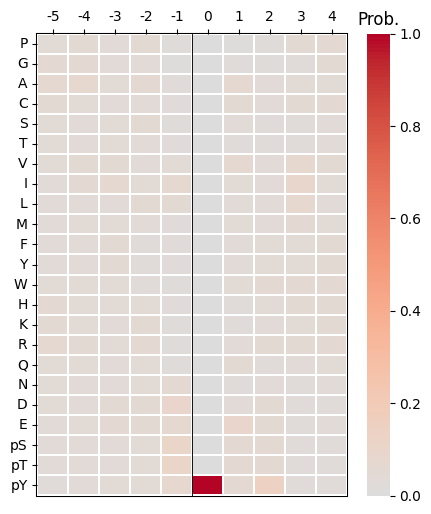

Q9UF33_EPHA6_HUMAN_KD1 pred


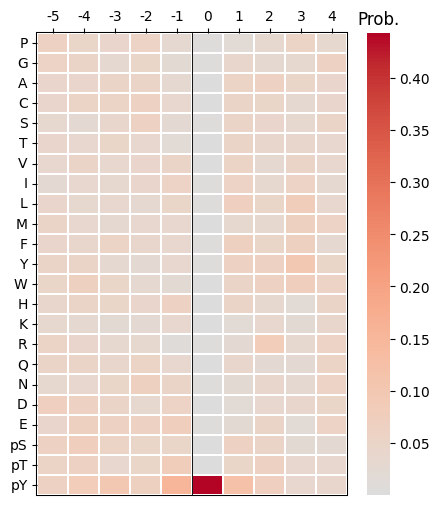

Q15375_EPHA7_HUMAN_KD1 target


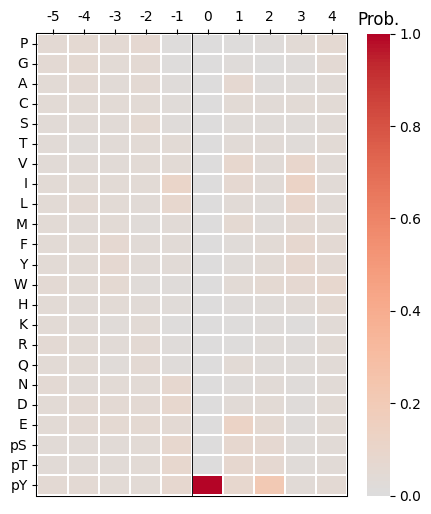

Q15375_EPHA7_HUMAN_KD1 pred


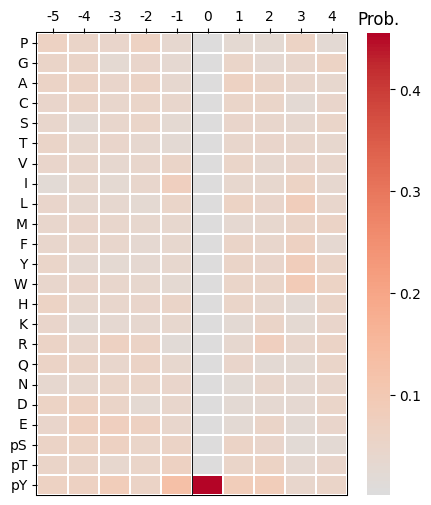

P29322_EPHA8_HUMAN_KD1 target


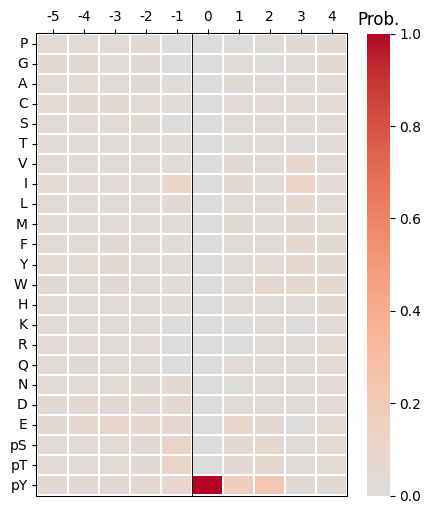

P29322_EPHA8_HUMAN_KD1 pred


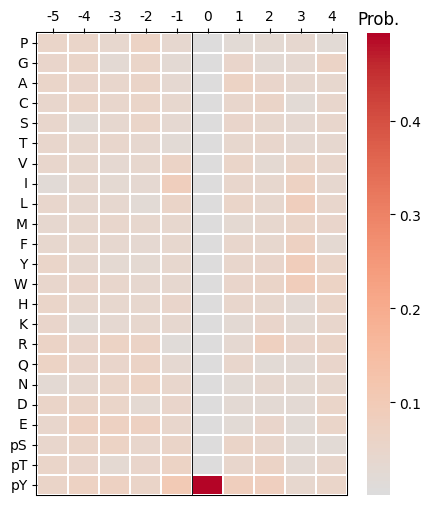

P54762_EPHB1_HUMAN_KD1 target


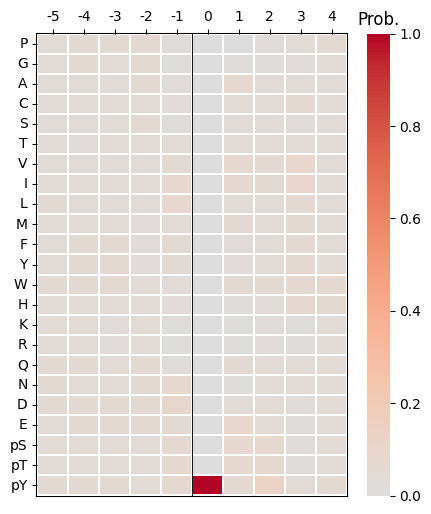

P54762_EPHB1_HUMAN_KD1 pred


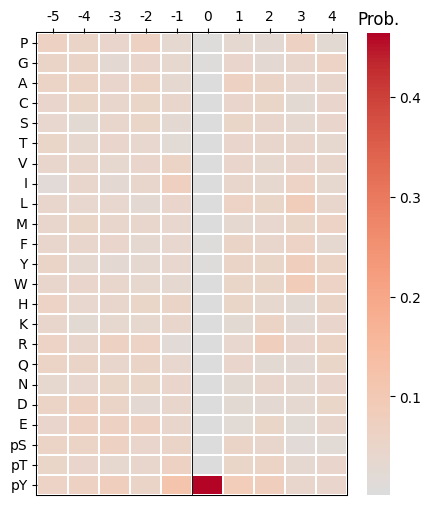

P29323_EPHB2_HUMAN_KD1 target


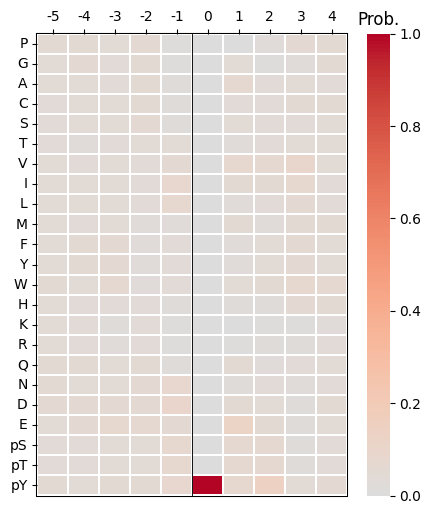

P29323_EPHB2_HUMAN_KD1 pred


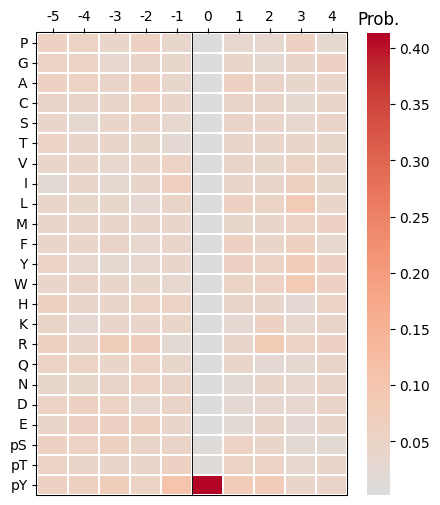

P54753_EPHB3_HUMAN_KD1 target


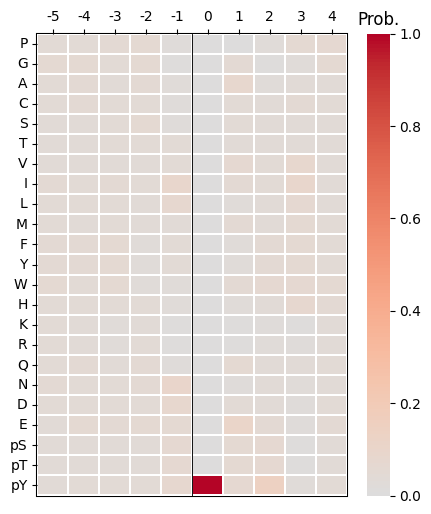

P54753_EPHB3_HUMAN_KD1 pred


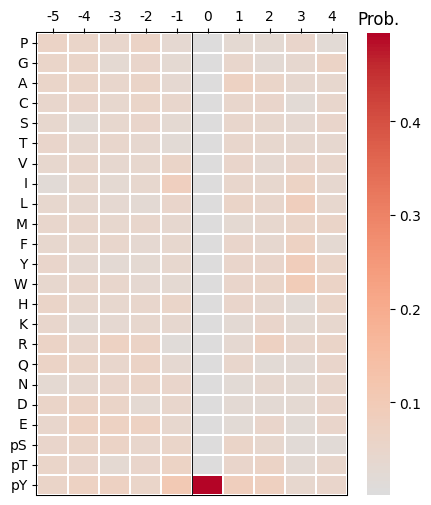

P54760_EPHB4_HUMAN_KD1 target


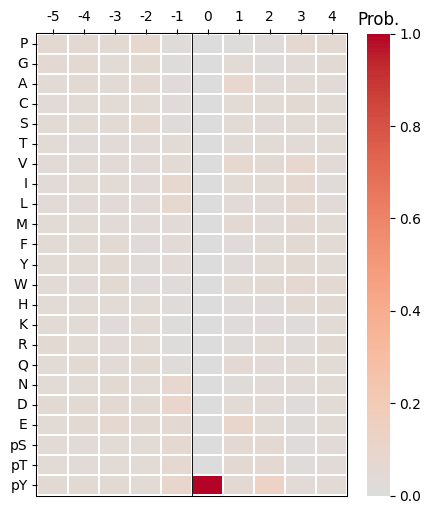

P54760_EPHB4_HUMAN_KD1 pred


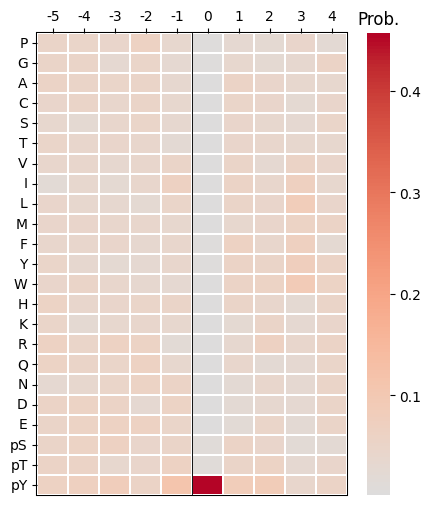

P51813_BMX_HUMAN_KD1 target


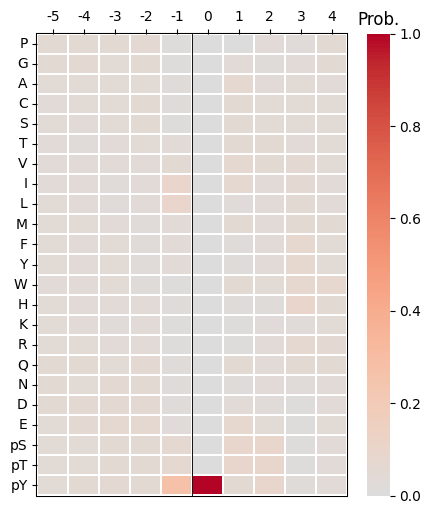

P51813_BMX_HUMAN_KD1 pred


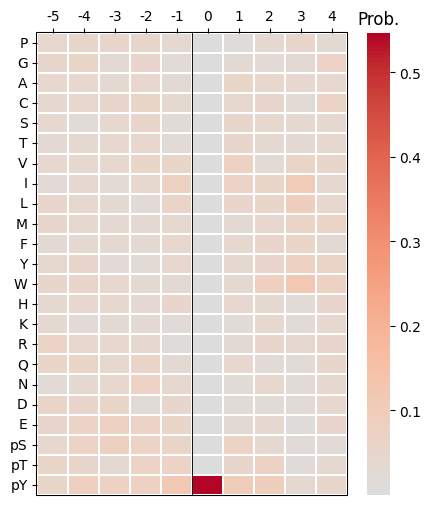

Q05397_FAK1_HUMAN_KD1 target


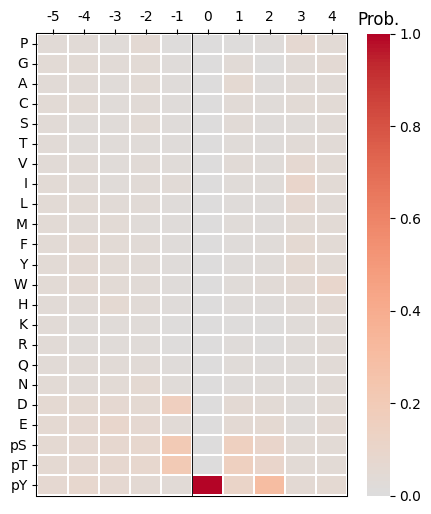

Q05397_FAK1_HUMAN_KD1 pred


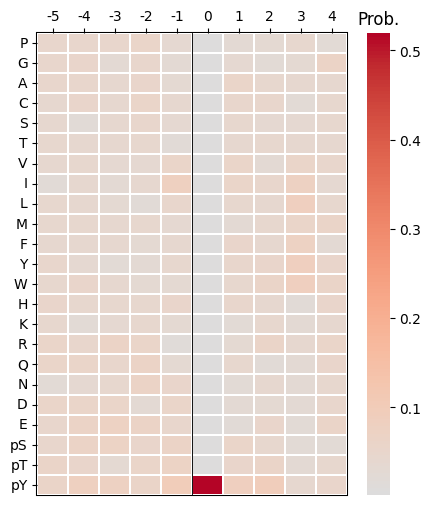

P16591_FER_HUMAN_KD1 target


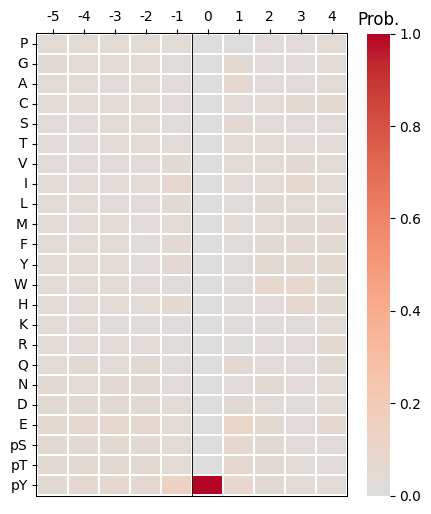

P16591_FER_HUMAN_KD1 pred


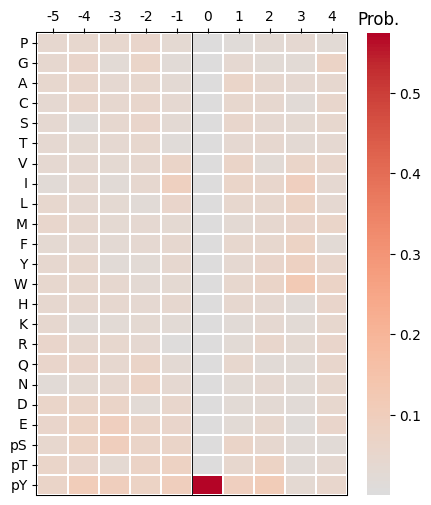

P07332_FES_HUMAN_KD1 target


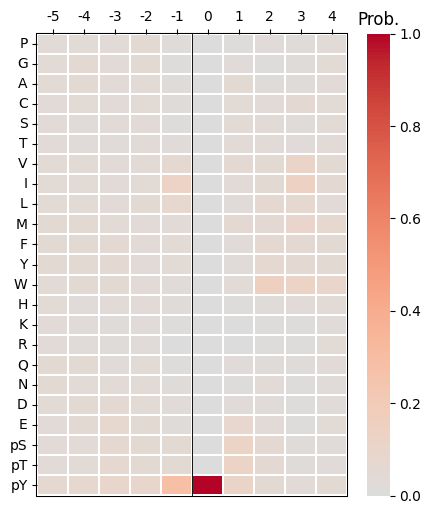

P07332_FES_HUMAN_KD1 pred


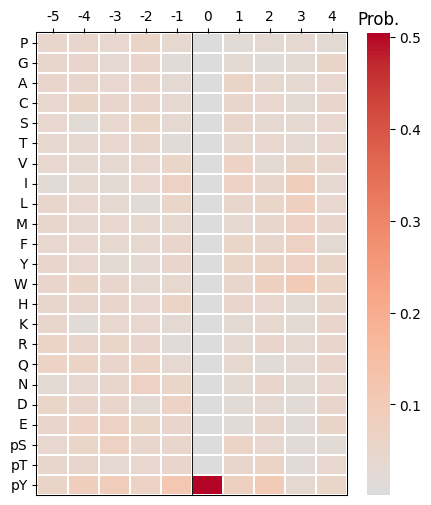

P11362_FGFR1_HUMAN_KD1 target


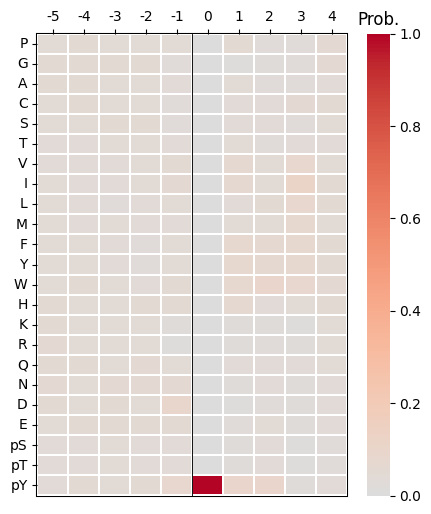

P11362_FGFR1_HUMAN_KD1 pred


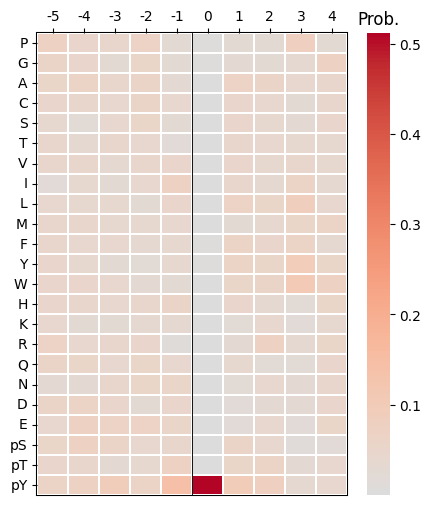

P21802_FGFR2_HUMAN_KD1 target


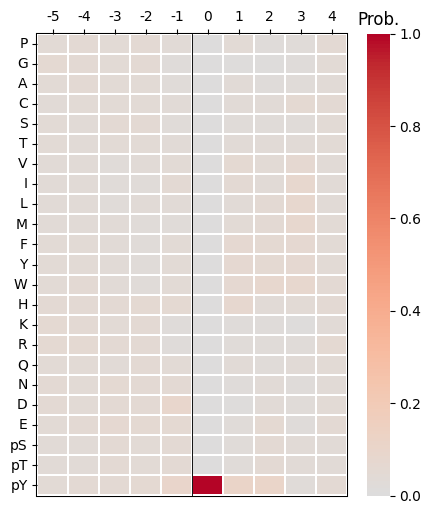

P21802_FGFR2_HUMAN_KD1 pred


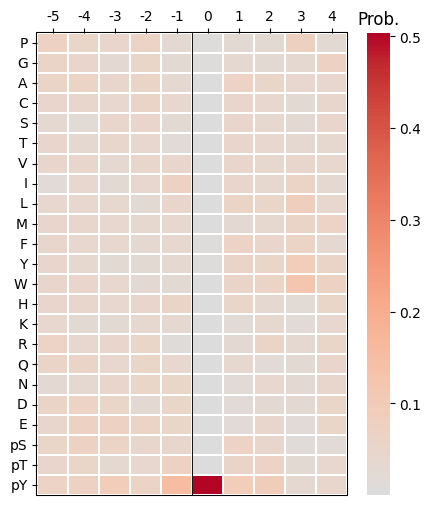

P22607_FGFR3_HUMAN_KD1 target


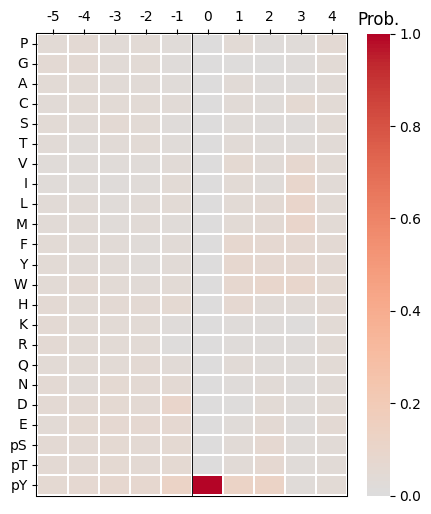

P22607_FGFR3_HUMAN_KD1 pred


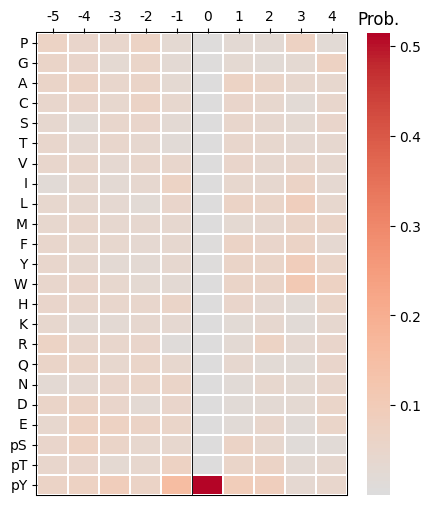

P22455_FGFR4_HUMAN_KD1 target


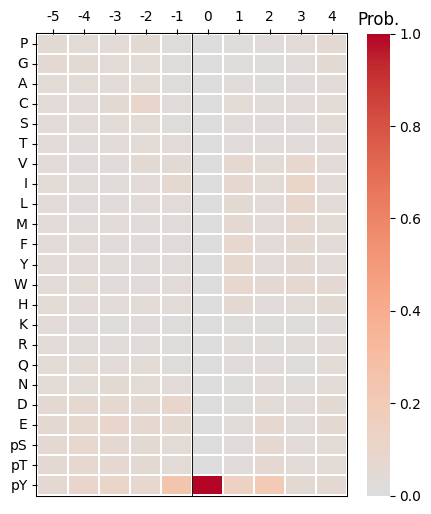

P22455_FGFR4_HUMAN_KD1 pred


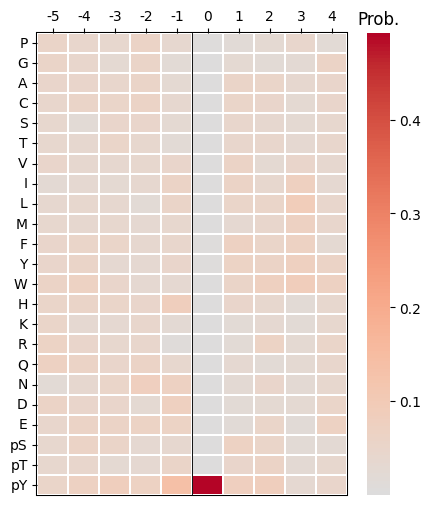

P04626_ERBB2_HUMAN_KD1 target


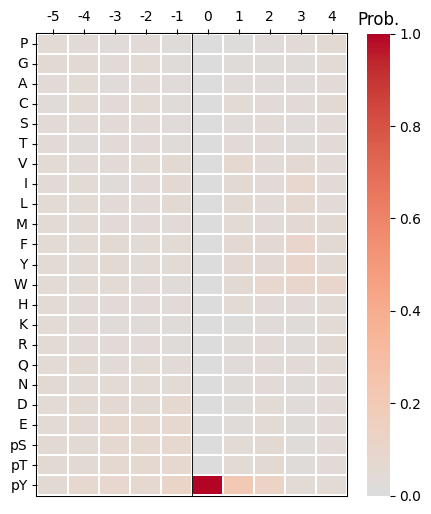

P04626_ERBB2_HUMAN_KD1 pred


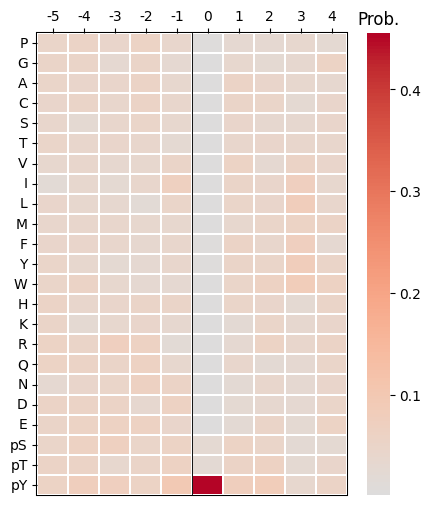

Q15303_ERBB4_HUMAN_KD1 target


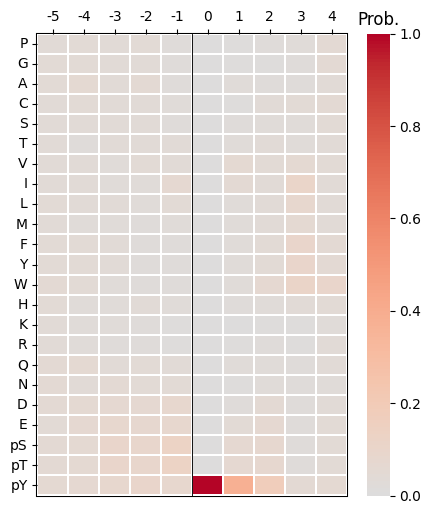

Q15303_ERBB4_HUMAN_KD1 pred


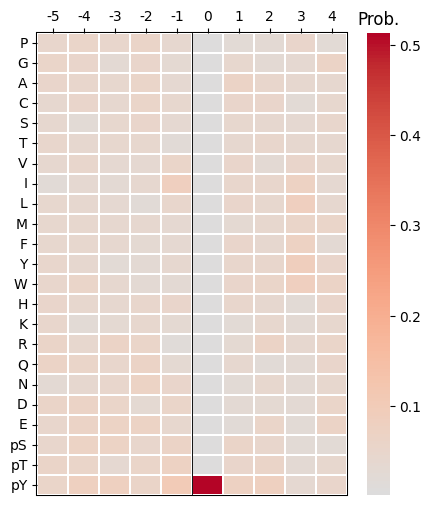

Q08881_ITK_HUMAN_KD1 target


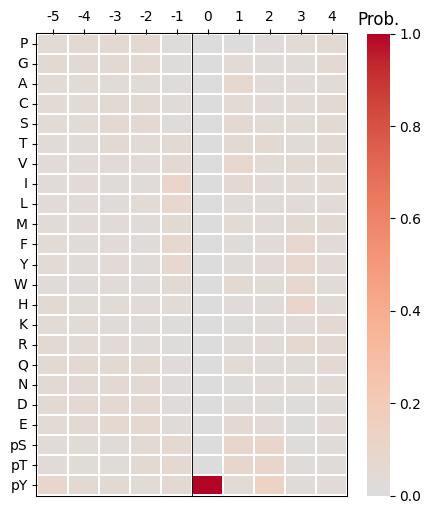

Q08881_ITK_HUMAN_KD1 pred


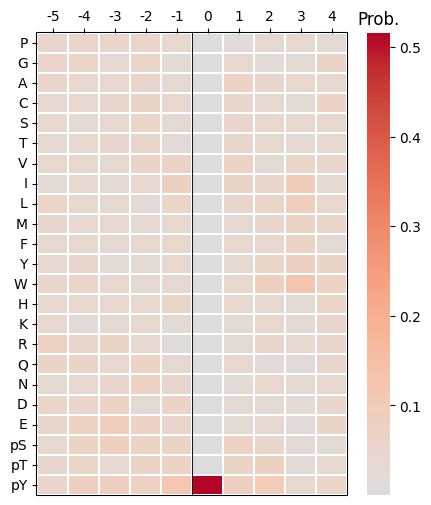

P29376_LTK_HUMAN_KD1 target


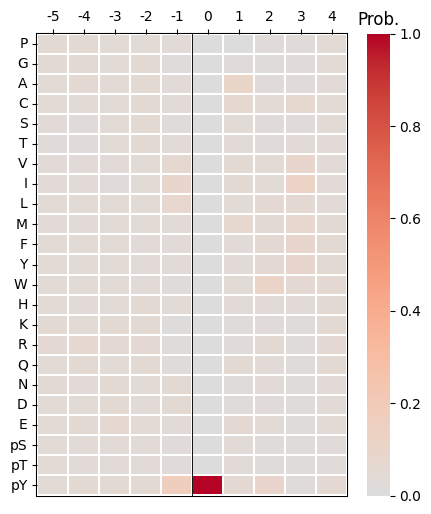

P29376_LTK_HUMAN_KD1 pred


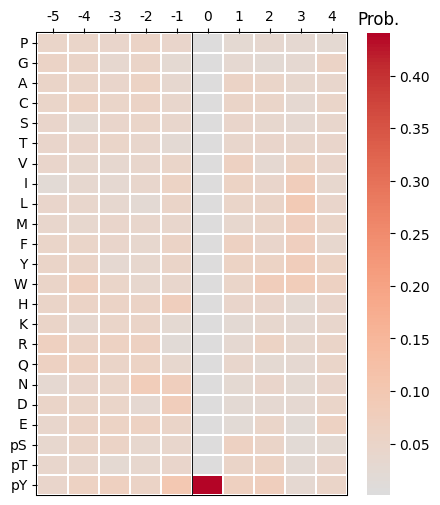

Q14289_FAK2_HUMAN_KD1 target


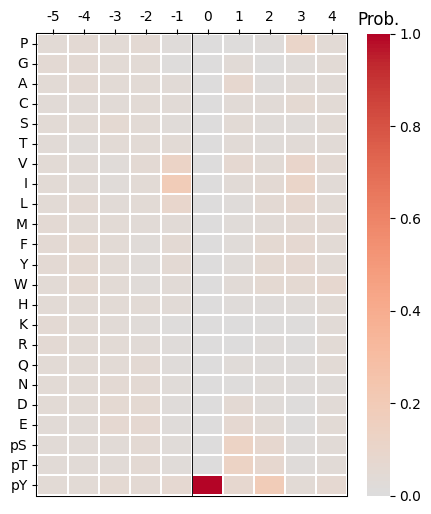

Q14289_FAK2_HUMAN_KD1 pred


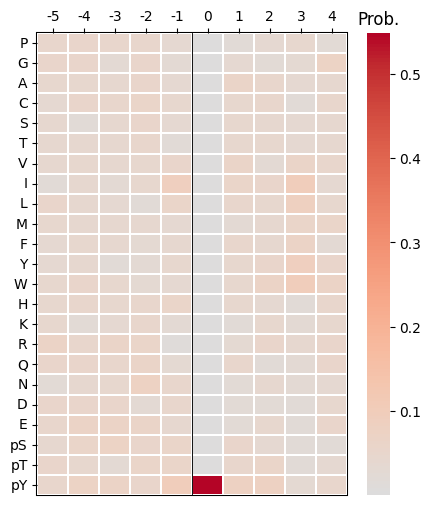

P42680_TEC_HUMAN_KD1 target


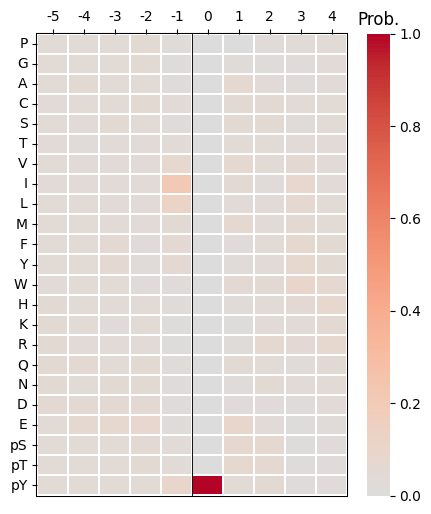

P42680_TEC_HUMAN_KD1 pred


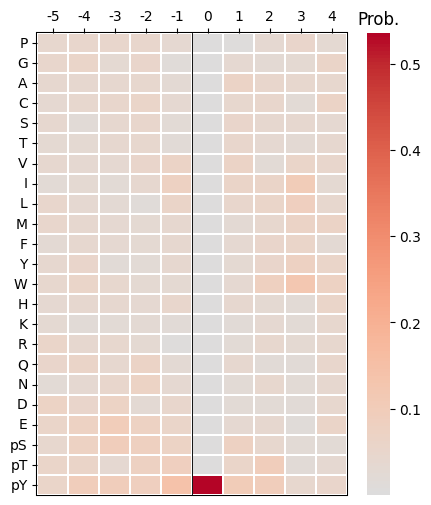

Q13470_TNK1_HUMAN_KD1 target


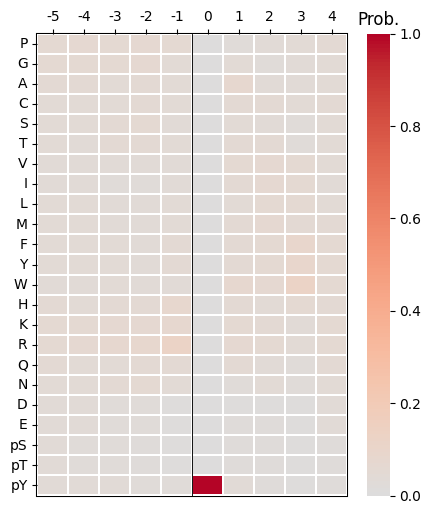

Q13470_TNK1_HUMAN_KD1 pred


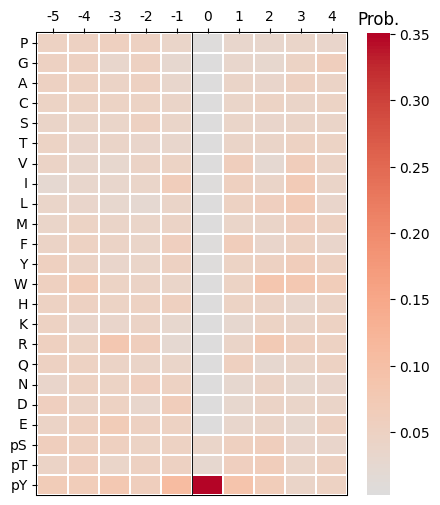

P42681_TXK_HUMAN_KD1 target


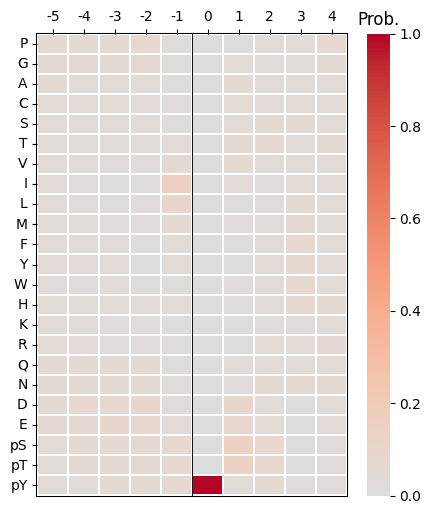

P42681_TXK_HUMAN_KD1 pred


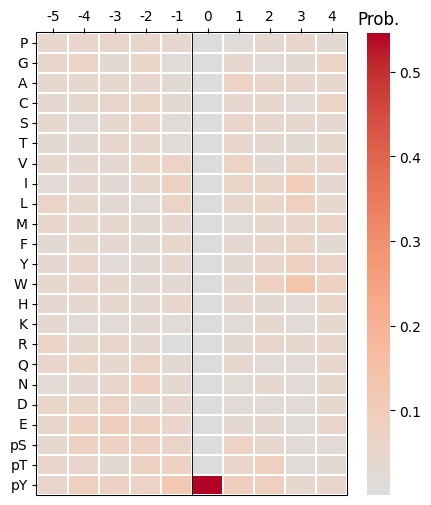

In [148]:
for i in pred.index:
    r = df[target_col].loc[i]
    r_pred = pred.loc[i]

    pssm = recover_pssm(r)
    pssm_pred = recover_pssm(r_pred)

    print(df.loc[i]['index'], 'target')
    plot_heatmap(pssm.reindex(index=list('PGACSTVILMFYWHKRQNDE')+['pS','pT','pY']))
    plt.show()
    plt.close()

    print(df.loc[i]['index'], 'pred')
    plot_heatmap(pssm_pred.reindex(index=list('PGACSTVILMFYWHKRQNDE')+['pS','pT','pY']))
    plt.show()
    plt.close()

    

In [137]:
AURKA = df[target_col].loc[14]

In [138]:
AURKA_pred = pred.loc[14]

In [139]:
from katlas.pssm import *

In [140]:
pssm = recover_pssm(AURKA)

In [141]:
pssm_pred = recover_pssm(AURKA_pred)

<Axes: >

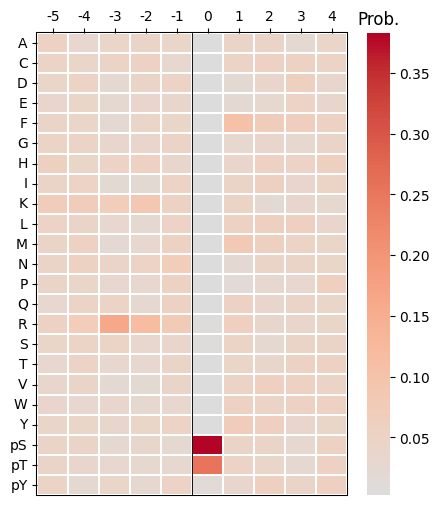

In [142]:
plot_heatmap(pssm_pred)

<Axes: >

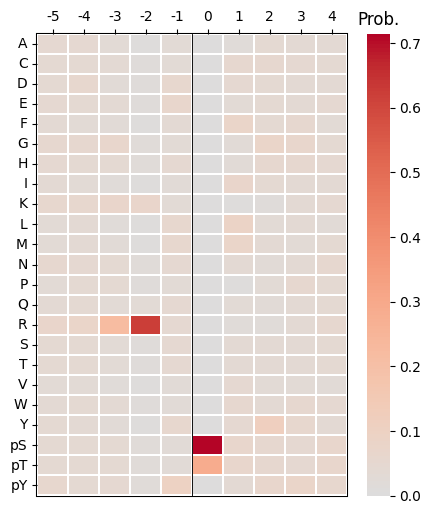

In [143]:
plot_heatmap(pssm)

In [123]:
df.loc[14]

index      O14965_AURKA_HUMAN_KD1
-5P                        0.0316
-5G                       0.05054
-5A                       0.04638
-5C                       0.04427
                    ...          
T5_1019                 -0.041168
T5_1020                 -0.030411
T5_1021                   -0.0075
T5_1022                  0.036987
T5_1023                 -0.023117
Name: 14, Length: 1255, dtype: object

In [117]:
target

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,...,4H,4K,4R,4Q,4N,4D,4E,4pS,4pT,4pY
14,0.03160,0.05054,0.04638,0.04427,0.04129,0.04129,0.03248,0.03743,0.03226,0.03095,...,0.04810,0.04859,0.05047,0.04332,0.05137,0.03700,0.04491,0.06234,0.06234,0.05838
15,0.04469,0.05619,0.04885,0.05055,0.04137,0.04137,0.03458,0.03882,0.03535,0.03566,...,0.04743,0.04913,0.04403,0.05735,0.04677,0.04292,0.03167,0.04714,0.04714,0.03411
16,0.05708,0.07434,0.06665,0.05902,0.03678,0.03678,0.03678,0.02885,0.02893,0.03033,...,0.04808,0.05389,0.04957,0.05895,0.05262,0.04190,0.02985,0.04659,0.04659,0.03506
36,0.04044,0.04142,0.05572,0.05143,0.04224,0.04224,0.04179,0.04119,0.04104,0.04209,...,0.04536,0.03236,0.03036,0.03286,0.03686,0.03821,0.03493,0.05650,0.05650,0.04829
37,0.04623,0.05562,0.04143,0.04562,0.03717,0.03717,0.02859,0.02987,0.03177,0.03021,...,0.05378,0.08011,0.05289,0.04456,0.04880,0.04121,0.03436,0.04136,0.04136,0.04716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.05000,0.05205,0.04620,0.04107,0.03649,0.03080,0.03578,0.03681,0.04384,0.03704,...,0.04899,0.04852,0.05637,0.05216,0.03615,0.03797,0.04194,0.02981,0.02981,0.05684
348,0.04471,0.05078,0.04567,0.03871,0.04351,0.03663,0.04111,0.04351,0.04607,0.04814,...,0.04510,0.03284,0.04044,0.04277,0.03066,0.03711,0.04145,0.03625,0.03625,0.06365
354,0.04194,0.04512,0.03907,0.03470,0.04067,0.03334,0.03923,0.03494,0.04074,0.04480,...,0.07096,0.05621,0.07376,0.04805,0.04104,0.03321,0.03090,0.02406,0.02406,0.03123
356,0.05724,0.05618,0.04909,0.04077,0.04525,0.04134,0.03767,0.03849,0.04093,0.04232,...,0.05099,0.05828,0.05953,0.05124,0.04463,0.03324,0.03282,0.01708,0.01708,0.02110


In [116]:
pred

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,...,4H,4K,4R,4Q,4N,4D,4E,4pS,4pT,4pY
14,0.050200,0.043806,0.059321,0.059604,0.036015,0.026056,0.037867,0.047748,0.071502,0.050052,...,0.055666,0.042522,0.040151,0.041345,0.045544,0.024396,0.026630,0.043002,0.046600,0.043834
15,0.046860,0.040417,0.047505,0.056739,0.043322,0.027728,0.038448,0.055193,0.061534,0.052948,...,0.052086,0.039432,0.038739,0.041524,0.038839,0.020783,0.028505,0.046744,0.049462,0.045276
16,0.047518,0.036171,0.046409,0.056726,0.042364,0.027767,0.039901,0.060724,0.070438,0.059624,...,0.051201,0.036849,0.038328,0.040774,0.036970,0.021422,0.027710,0.044221,0.048105,0.042464
36,0.043337,0.045316,0.059089,0.060821,0.044465,0.029395,0.035122,0.045567,0.042212,0.042000,...,0.058803,0.036375,0.040668,0.046173,0.037700,0.024393,0.036553,0.057269,0.048997,0.063036
37,0.065121,0.059882,0.054036,0.058354,0.047303,0.030509,0.030568,0.041968,0.031774,0.042620,...,0.074646,0.078093,0.077652,0.053300,0.051857,0.016327,0.013626,0.030098,0.018941,0.029030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,0.040773,0.058246,0.053897,0.046487,0.044460,0.047930,0.039042,0.020694,0.036011,0.047318,...,0.043782,0.045524,0.056172,0.047773,0.040001,0.051095,0.058479,0.021705,0.045291,0.046663
348,0.048056,0.050906,0.056758,0.050916,0.038482,0.045241,0.048235,0.021784,0.044645,0.040619,...,0.050702,0.050589,0.060773,0.055029,0.042730,0.040719,0.046601,0.016699,0.037289,0.043090
354,0.039391,0.053561,0.053899,0.054859,0.032062,0.045651,0.048455,0.018479,0.036628,0.043893,...,0.045918,0.053842,0.062746,0.053248,0.042368,0.044898,0.053134,0.014862,0.043202,0.047826
356,0.037797,0.049883,0.048841,0.041755,0.042430,0.051304,0.029252,0.021349,0.030909,0.045653,...,0.040045,0.038791,0.046649,0.042426,0.033164,0.057127,0.062674,0.035873,0.063651,0.057822


In [110]:
score_each(target,pred)

overall MSE: 1.9374
Average Pearson: 0.4332 


(1.9374381311487365,
 np.float64(0.4331924877498997),
       Pearson
 14   0.411643
 15   0.448737
 16   0.434665
 36   0.414174
 37   0.474697
 ..        ...
 340  0.405595
 348  0.406760
 354  0.370342
 356  0.296997
 360  0.345502
 
 [74 rows x 1 columns])

In [ ]:
score_each(target,pred)

overall MSE: 1.2313
Average Pearson: 0.1580 


(1.2313209,
 0.1579942852920301,
       Pearson
 3   -0.037969
 8   -0.045367
 10  -0.057115
 19  -0.044484
 24  -0.059326
 ..        ...
 359  0.247093
 361 -0.147023
 366  0.107366
 367 -0.004609
 373  0.260843
 
 [78 rows x 1 columns])

## DL CV

In [ ]:
#| export
@fc.delegates(train_dl)
def train_dl_cv(df, 
                feat_col, 
                target_col, 
                splits, # list of tuples
                model_func, # functions like lambda x: return MLP_1(num_feat, num_target)
                save:str=None,
                **kwargs
                ):
    
    OOF = []
    metrics = []
    
    for fold,split in enumerate(splits):

        print(f'------fold{fold}------')
        
        
        fname=None
        # save best model for each fold
        if save is not None:
            fname = f'{save}_fold{fold}'
        
        # train model
        target, pred = train_dl(df,feat_col,target_col, split, model_func ,save=fname,**kwargs)

        #------------get scores--------------
        # get score metrics
        mse, pearson_avg, _ = score_each(target,pred)
        
        # store metrics in a dictionary for the current fold
        fold_metrics = {
            'fold': fold,
            'mse': mse,
            'pearson_avg': pearson_avg
        }
        metrics.append(fold_metrics)

        OOF.append(pred)
        

    # Concatenate OOF from each fold to a new dataframe
    oof = pd.concat(OOF).sort_index()
    
    # Get metrics into a dataframe
    metrics = pd.DataFrame(metrics)
    
    return oof, metrics

In [ ]:
oof,metrics = train_dl_cv(df,feat_col,target_col,splits,get_model,n_epoch=1,lr=3e-3)

------fold0------
lr in training is 0.003


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.157886,0.985997,0.123256,0.076049,00:01


overall MSE: 0.9860
Average Pearson: 0.2104 
------fold1------
lr in training is 0.003


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.194019,0.984086,0.130521,0.092631,00:01


overall MSE: 0.9841
Average Pearson: 0.1521 
------fold2------
lr in training is 0.003


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.154190,0.988698,0.114616,0.064543,00:01


overall MSE: 0.9887
Average Pearson: 0.2677 
------fold3------
lr in training is 0.003


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.177719,0.975760,0.156240,0.125270,00:01


overall MSE: 0.9758
Average Pearson: 0.1862 
------fold4------
lr in training is 0.003


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


epoch,train_loss,valid_loss,pearsonr,spearmanr,time
0,1.170352,0.983774,0.135724,0.102884,00:01


overall MSE: 0.9838
Average Pearson: 0.2547 


In [ ]:
metrics

,fold,mse,pearson_avg
0,0,0.985997,0.210434
1,1,0.984086,0.152108
2,2,0.988698,0.267718
3,3,0.975760,0.186243
4,4,0.983774,0.254678


In [ ]:
metrics.pearson_avg.mean()

0.2142360341441809

In [ ]:
target = df[target_col]
_,_,corr = score_each(target,oof)

overall MSE: 0.9837
Average Pearson: 0.2142 


In [ ]:
corr

,Pearson
0,-0.130073
1,-0.210985
2,-0.251176
3,-0.163586
4,-0.054230
...,...
385,0.186961
386,0.336823
387,-0.029309
388,0.029152


## DL Predict

In [ ]:
#| export
def predict_dl(df, 
               feat_col, 
               target_col,
               model, # model architecture
               model_pth, # only name, not with .pth
              ):
    
    "Predict dataframe given a deep learning model"
    
    test_dset = GeneralDataset(df,feat_col)
    test_dl = DataLoader(test_dset,bs=512)
    
    
    learn = Learner(None, model.to(def_device), loss_func=1)
    learn.load(model_pth,weights_only=False)
    
    learn.model.eval()
    
    preds = []
    for data in test_dl:
        inputs = data.to(def_device)
        outputs = learn.model(inputs) #learn.model(x).sigmoid().detach().cpu().numpy()

        preds.append(outputs.detach().cpu().numpy())

    preds = np.concatenate(preds)
    preds = pd.DataFrame(preds,index=df.index,columns=target_col)

    return preds

In [ ]:
test = df.loc[split0[1]]

In [ ]:
pred = predict_dl(test.head(3),
                  feat_col,
                  target_col, 
                  model,'test')
pred

,-5P,-5G,-5A,-5C,-5S,-5T,-5V,-5I,-5L,-5M,...,4Q,4N,4D,4E,4s,4t,4y,0s,0t,0y
3,-0.355736,-0.371514,-0.814290,-0.573196,1.173128,0.863355,-0.738675,0.366732,0.702826,1.137061,...,-0.286256,-0.485139,0.012519,0.306050,-0.215432,0.959879,0.697288,0.805923,0.199813,-0.397550
8,-0.322134,-0.418208,-0.835480,-0.620543,1.237427,0.920613,-0.783180,0.385320,0.750605,1.191602,...,-0.300988,-0.502365,-0.041983,0.355885,-0.245259,1.002593,0.699817,0.878045,0.185331,-0.444951
10,-0.349195,-0.373037,-0.816447,-0.580855,1.182283,0.871513,-0.739842,0.368429,0.705171,1.146074,...,-0.286629,-0.483317,0.007166,0.306860,-0.217535,0.966914,0.695795,0.811916,0.201817,-0.403425


In [ ]:
_,_,corr = score_each(test[target_col].head(3),pred)

overall MSE: 1.4146
Average Pearson: 0.0468 


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()